In [1]:
import sys
import os
from pathlib import Path
from hydra import initialize, compose
initialize(config_path="../confs", job_name="notebook")

sys.path.append(os.path.abspath("../src"))
# We change the working directory to the root of the project
# Run this only once
root_path = Path.cwd().parent
os.chdir(root_path)
sys.path.append(root_path / "src")

/tmp/ipykernel_29632/1901343020.py:5: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  initialize(config_path="../confs", job_name="notebook")


In [2]:
from src.utils import torch_to_pil
from src.character_linking.feature_matching import featureMatching
from src.character_linking.params import HOGParameters, featureMatchingParameters, fullHOGOutput, featureMatchingOutputs
from src.utils import connectedComponent
from src.patch_processing.patch_extraction import extract_patches

from notebook_utils.descriptor import compute_hog, visualize_hog

from einops import rearrange
import torch

import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tqdm

from PIL import Image

image_folder = Path('data/datasets/book1')
comps_folder = Path('data/extracted/book1-complete/components/')
assert image_folder.exists()
assert comps_folder.exists()
files = next(os.walk(image_folder))[2]

# Pipeline

This notebook presents the pipeline used to construct groups of similar hànzì. The process consists of the following steps:

1. Pre-processing
2. Normalization
3. Histogram of Oriented Gradients (HOG)
4. A-contrario matching
5. Graph construction
6. Graph clustering

---

# Pre-processing

We begin by extracting image patches of individual characters from the source book and applying a series of pre-processing steps. First, the patches are vectorized using **Binary Shape Vectorization by Affine Scale-Space**, a method developed by Yuchen He.

This technique converts binary input images into smooth SVG representations composed of Bézier curves. As a result, we obtain cleaner and smoother hànzì shapes, free from noise and JPEG compression artifacts.

Subsequently, we render them at a higher resolution and apply additional filtering steps to remove ink defects and spurious artifacts within the character shapes.

We now proceed by extracting the character patches and their corresponding binarized images from the document. Note that the binarized images are directly taken from the outputs of the hànzì extraction notebook. Regions predicted as not belonging to the actual character are excluded from the displayed patches.


100%|██████████| 38/38 [00:29<00:00,  1.30it/s]


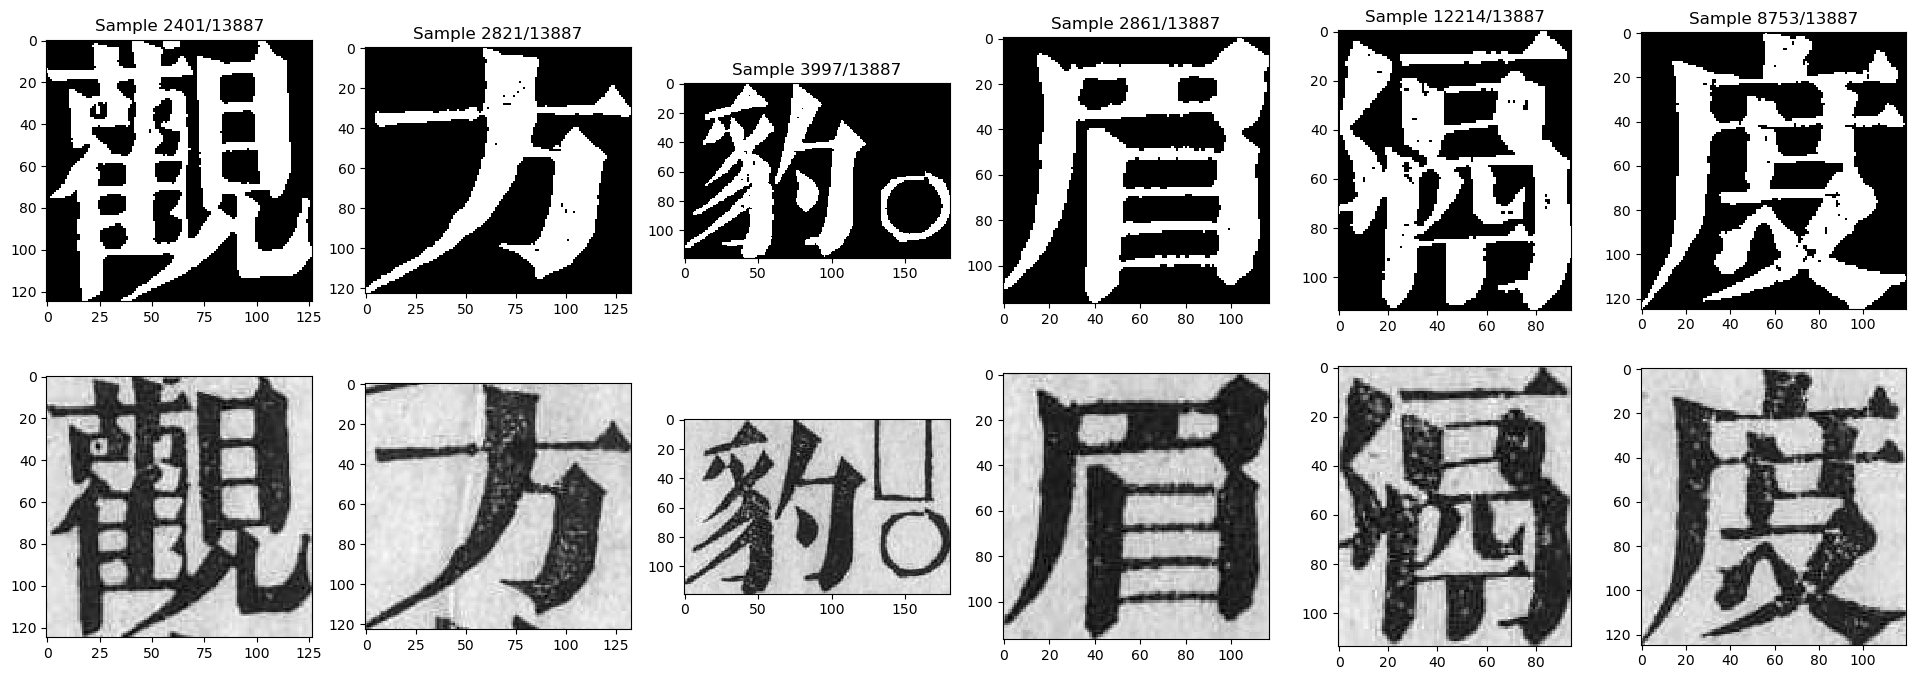

In [3]:
patches_df = pd.DataFrame(columns=['bin_patch', 'img_patch', 'page', 'region', 'left', 'top', 'width', 'height'])

# Main loop
for i, file in tqdm.tqdm(list(enumerate(files))):
    
    
    # Load the image / components
    img_np = np.array(Image.open(image_folder / file))
    img_np = cv2.cvtColor(img_np, cv2.COLOR_RGB2GRAY)[..., None]
    # img_torch = torch.tensor(img_np, device=patches_device, dtype=patches_dtype).permute(2,0,1).float() / 255
    # img_torch.requires_grad = False
    img_comp = connectedComponent.load(comps_folder / (str(file) + '.npz'))
    
    _bin_patches, _img_patches = extract_patches(
        characterComponents=img_comp,
        images = [img_np],
        return_bin=True
    )

    stats = img_comp.stats[1:]

    page_df = pd.DataFrame({
        'bin_patch': _bin_patches,
        'img_patch': _img_patches,
        'page': i,
        'region': img_comp.regions,
        'left': stats[:,0],
        'top': stats[:, 1],
        'width': stats[:,2],
        'height': stats[:, 3]
    })
    
    # Concatenate immediately
    patches_df = pd.concat([patches_df, page_df], ignore_index=True)


from src.patch_processing.svg import SVG
def show_random_sample(*args, n_samples, indices=None, titles=None, **kwargs):
    indices = np.random.randint(0, len(args[0]), n_samples) if indices is None else indices
    n_samples = min(n_samples, len(indices))
    fig, axes = plt.subplots(len(args), n_samples, figsize=(4*n_samples, 4*len(args)), squeeze=False)
    
    for row, arr in enumerate(args):
        for col, idx in enumerate(indices):
            ax = axes[row, col]
            img = arr[idx]

            if row == 0:
                if titles is None:
                    ax.set_title(f'Sample {idx}/{len(args[0])}')
                else:
                    ax.set_title(f'Sample {idx}/{len(args[0])} \n {titles[0]}')

            elif titles is not None:
                ax.set_title(f'{titles[row]}')
            if type(img) == SVG:
                img = img.render(**kwargs)
            
            if type(img) == np.ndarray:
                if img.shape[-1] == 1:
                    img = img[..., 0]

                cmap = "gray" if img.ndim == 2 else None
                ax.imshow(img, cmap=cmap, interpolation='nearest')

show_random_sample(patches_df['bin_patch'], patches_df['img_patch'], n_samples=6)

**We now proceed to vectorizing the hànzi**

In [4]:
from IPython.display import display, Markdown
from hydra.utils import instantiate
from operator import itemgetter
from omegaconf import OmegaConf
from src.patch_processing.normalization import compute_normalization_homography, compute_svg_normalization_homography
from src.patch_processing import filter_binary_patch
from IPython.display import SVG as IPYSVG
from tqdm import tqdm
os.environ["HYDRA_FULL_ERROR"] = "1"


# ==== Instantiate the vectorizer ====

#? See configs/vectorizer.yaml
cfg = compose(config_name="vectorizer")
vect = instantiate(cfg)

#? We show the content of the config 
display(Markdown(f"```yaml\n{OmegaConf.to_yaml(cfg)}\n```"))



#! ==== CACHING ====

if True:
    svg_imgs = []
    for i in tqdm(range(len(patches_df)), desc="Loading vectorized images", unit="img", colour='green'):
        svg_imgs.append(SVG.load(Path(cfg.config.save_dir) / f'output_{i:06d}.svg'))

#! ==== Vectorize the images ===

else:
    inverted = [~p for p in patches_df['bin_patch']]
    svg_imgs = []
    for svg in tqdm(vect(inverted), total=len(inverted), desc="Vectorizing images", unit="img", colour='green'): # <-- iterator over the images | gathers data in parallel and yields it
        svg_imgs.append(svg)

    del inverted # free some memory

    svg_imgs = sorted(svg_imgs, key=itemgetter(0))
    svg_imgs = [el[1] for el in svg_imgs]



# ==== Compute the bboxes of every SVG image ===

bboxes = []
for svg_object in tqdm(svg_imgs, desc="Computing bounding boxes", unit="svg", colour='blue'):
    bboxes.append(svg_object._compute_bbox())

bboxes = np.array(bboxes)
aspect_ratio = bboxes[:, 2] / bboxes[:, 3]

print('Image with max aspect ratio: ', np.maximum(aspect_ratio, 1/aspect_ratio).argmax())

# ==== Align the SVGs ====
# Not used at the moment
# We found that it did not really work well.

# from src.patch_processing.normalization import process_svg

# #? Show two examples for demo purposes
# scale = 4

# i = np.random.randint(0, len(svg_imgs))
# print(f'Visualizing index {i}')
# idx, svg_object = svg_imgs[i]
# process_svg(image=img_patches[idx], svg_object=svg_object, display=True, scale=scale)
# i = np.random.randint(0, len(svg_imgs))
# print(f'Visualizing index {i}')
# idx, svg_object = svg_imgs[i]
# process_svg(image=img_patches[idx], svg_object=svg_object, display=True, scale=scale)

# #! Process the rest
# scale = 1
# for i, (idx, svg_object) in enumerate(tqdm(svg_imgs, desc="Processing & saving SVGs", unit="svg", colour='magenta')):
#     process_svg(image=img_patches[idx], svg_object=svg_object, display=False, scale=scale)
#     svg_object.save(f'output_svg_aligned/output_{i:06d}.svg')

2025-12-22 11:31:52,822 - INFO - Initialized vectorizer:
2025-12-22 11:31:52,822 - INFO -   output_size: (512, 512)
2025-12-22 11:31:52,823 - INFO -   background_color: (255, 255, 255, 255)
2025-12-22 11:31:52,823 - INFO -   output_format: L


```yaml
_target_: src.vectorization.BinaryShapeVectorizer
config:
  _target_: src.vectorization.VectorizerConfig
  executable_path: ./build/main
  smoothing_scale: 1
  accuracy_threshold: 0.1
  refinement_iterations: 0
  output_type: shape_merged
  return_svg: true
  return_svg_string: false
  return_rendered: false
  save_dir: ./outputs_svg
  output_size:
  - 512
  - 512
  background_color:
  - 255
  - 255
  - 255
  - 255
  dpi: 2048
  scale: 1.0
  output_format: L
  n_jobs: -1
  show_progress: true
  chunk_size: 100
  stream_results: true
  stream_parallel: true

```

Computing bounding boxes: 100%|██████████| 13887/13887 [00:00<00:00, 27780.36svg/s]


Image with max aspect ratio:  4213


Maximum aspect ratio:  SVG(123.0×25.8, 1 paths, original_viewbox=(0.0, 0.0, 123.0, 41.0))


With the biggest width: SVG(192.2×119.5, 1 paths, original_viewbox=(0.0, 0.0, 191.0, 120.0))


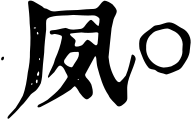

In [5]:
patches_df['svg'] = svg_imgs
aspect_ratio = patches_df['width'] / patches_df['height']
patches_df['aspect_ratio'] = aspect_ratio
i_max = np.maximum(aspect_ratio, 1/aspect_ratio).argmax()
print('Maximum aspect ratio: ',patches_df['svg'][i_max] )
patches_df['svg'][i_max].render_svg()

i_max = bboxes[:, 2].argmax()
print('With the biggest width:', patches_df['svg'][i_max])
patches_df['svg'][i_max].render_svg()

Rendering: 100%|██████████| 60/60 [00:00<00:00, 91.43img/s]


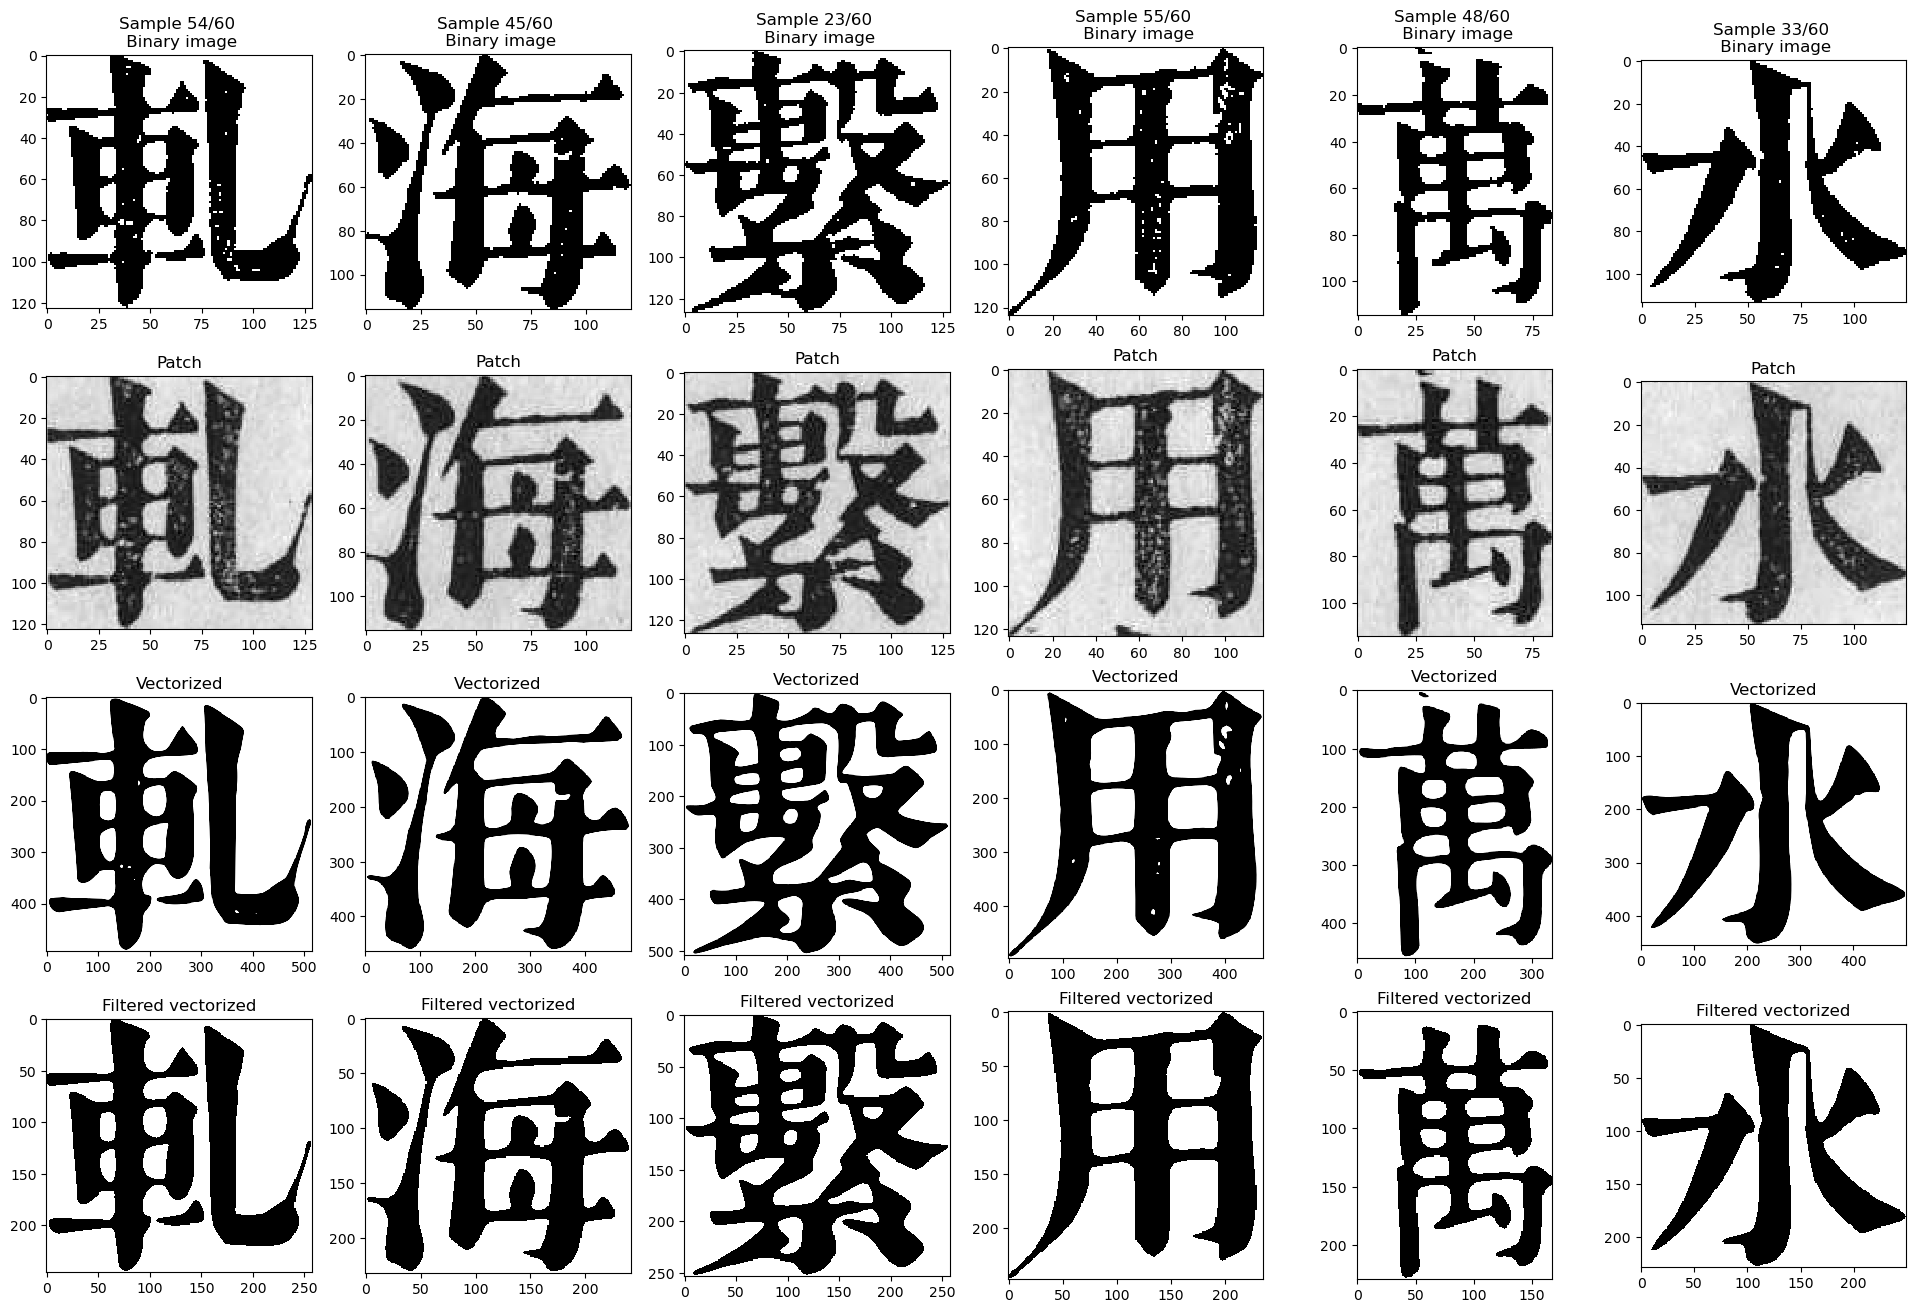

In [6]:
filtered_images = []

dpi = 256
scale = 2
min_size_black=75*scale**2,
min_size_white=20*scale**2,


N = 60


for svg_object in tqdm(patches_df['svg'][:N], desc="Rendering", unit="img"):

    #? Render
    svg_rendered = svg_object.render(
        dpi=dpi, 
        output_format='L', 
        scale=scale,
    )
    
    #? Binarize
    binary_svg = svg_rendered > 128
    
    #? Filter
    filtered = filter_binary_patch(
        binary_svg, 
        min_size_black=min_size_black, 
        min_size_white=min_size_white, 
    )
    
    filtered_images.append(filtered)


show_random_sample(~patches_df['bin_patch'][:N], patches_df['img_patch'][:N], patches_df['svg'][:N], filtered_images[:N], n_samples=6, scale=4, titles=['Binary image', 'Patch', 'Vectorized', 'Filtered vectorized'])

<Axes: >

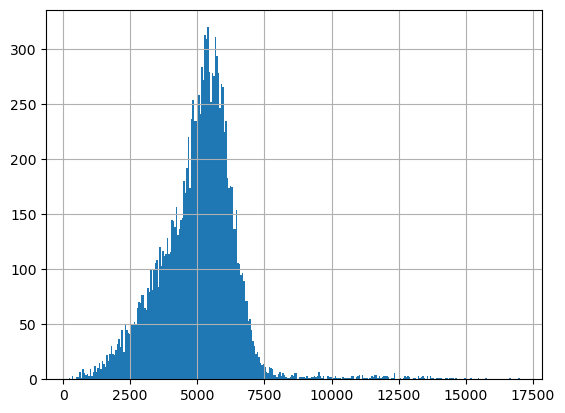

In [7]:
patches_df['bin_patch'].map(lambda x: x.sum()).hist(bins=300)

In [8]:
def show_row(row):

    file = files[row['page']]
    img_np = np.array(Image.open(image_folder / file))
    print(img_np.shape)

    left, top, w, h = row[['left', 'top', 'width', 'height']]
    
    # Draw rectangle on a copy of the image
    img_with_rect = img_np.copy()
    cv2.rectangle(img_with_rect, (left, top), (left+w, top+h), (255, 0, 0), 8)
    
    # Display the image with rectangle
    plt.figure(figsize=(16,9))
    plt.imshow(img_with_rect)
    plt.title(f"Page: {row['page']}, Position: ({left}, {top}) ; filename: {file}")
    plt.axis('off')
    plt.show()




In [9]:
# I = patches_df['region'].map(lambda x: x.intensity_image.sum())/255

# for i, row in patches_df[I < 800].iterrows():
#     plt.imshow(row['bin_patch'])
#     print('Size: ', I[i])
#     print(row['page'])
#     print(row['top'], ' , ', row['left'])
#     plt.show()
#     show_row(row)

528, 527 sont deux exemples de comment la normalisation par les moments peut être un problème

Rendering: 100%|██████████| 13887/13887 [01:13<00:00, 189.28img/s]


Canvas dimensions: w=256, h=320, cx=126, cy=154
Canvas size: 256×320 pixels


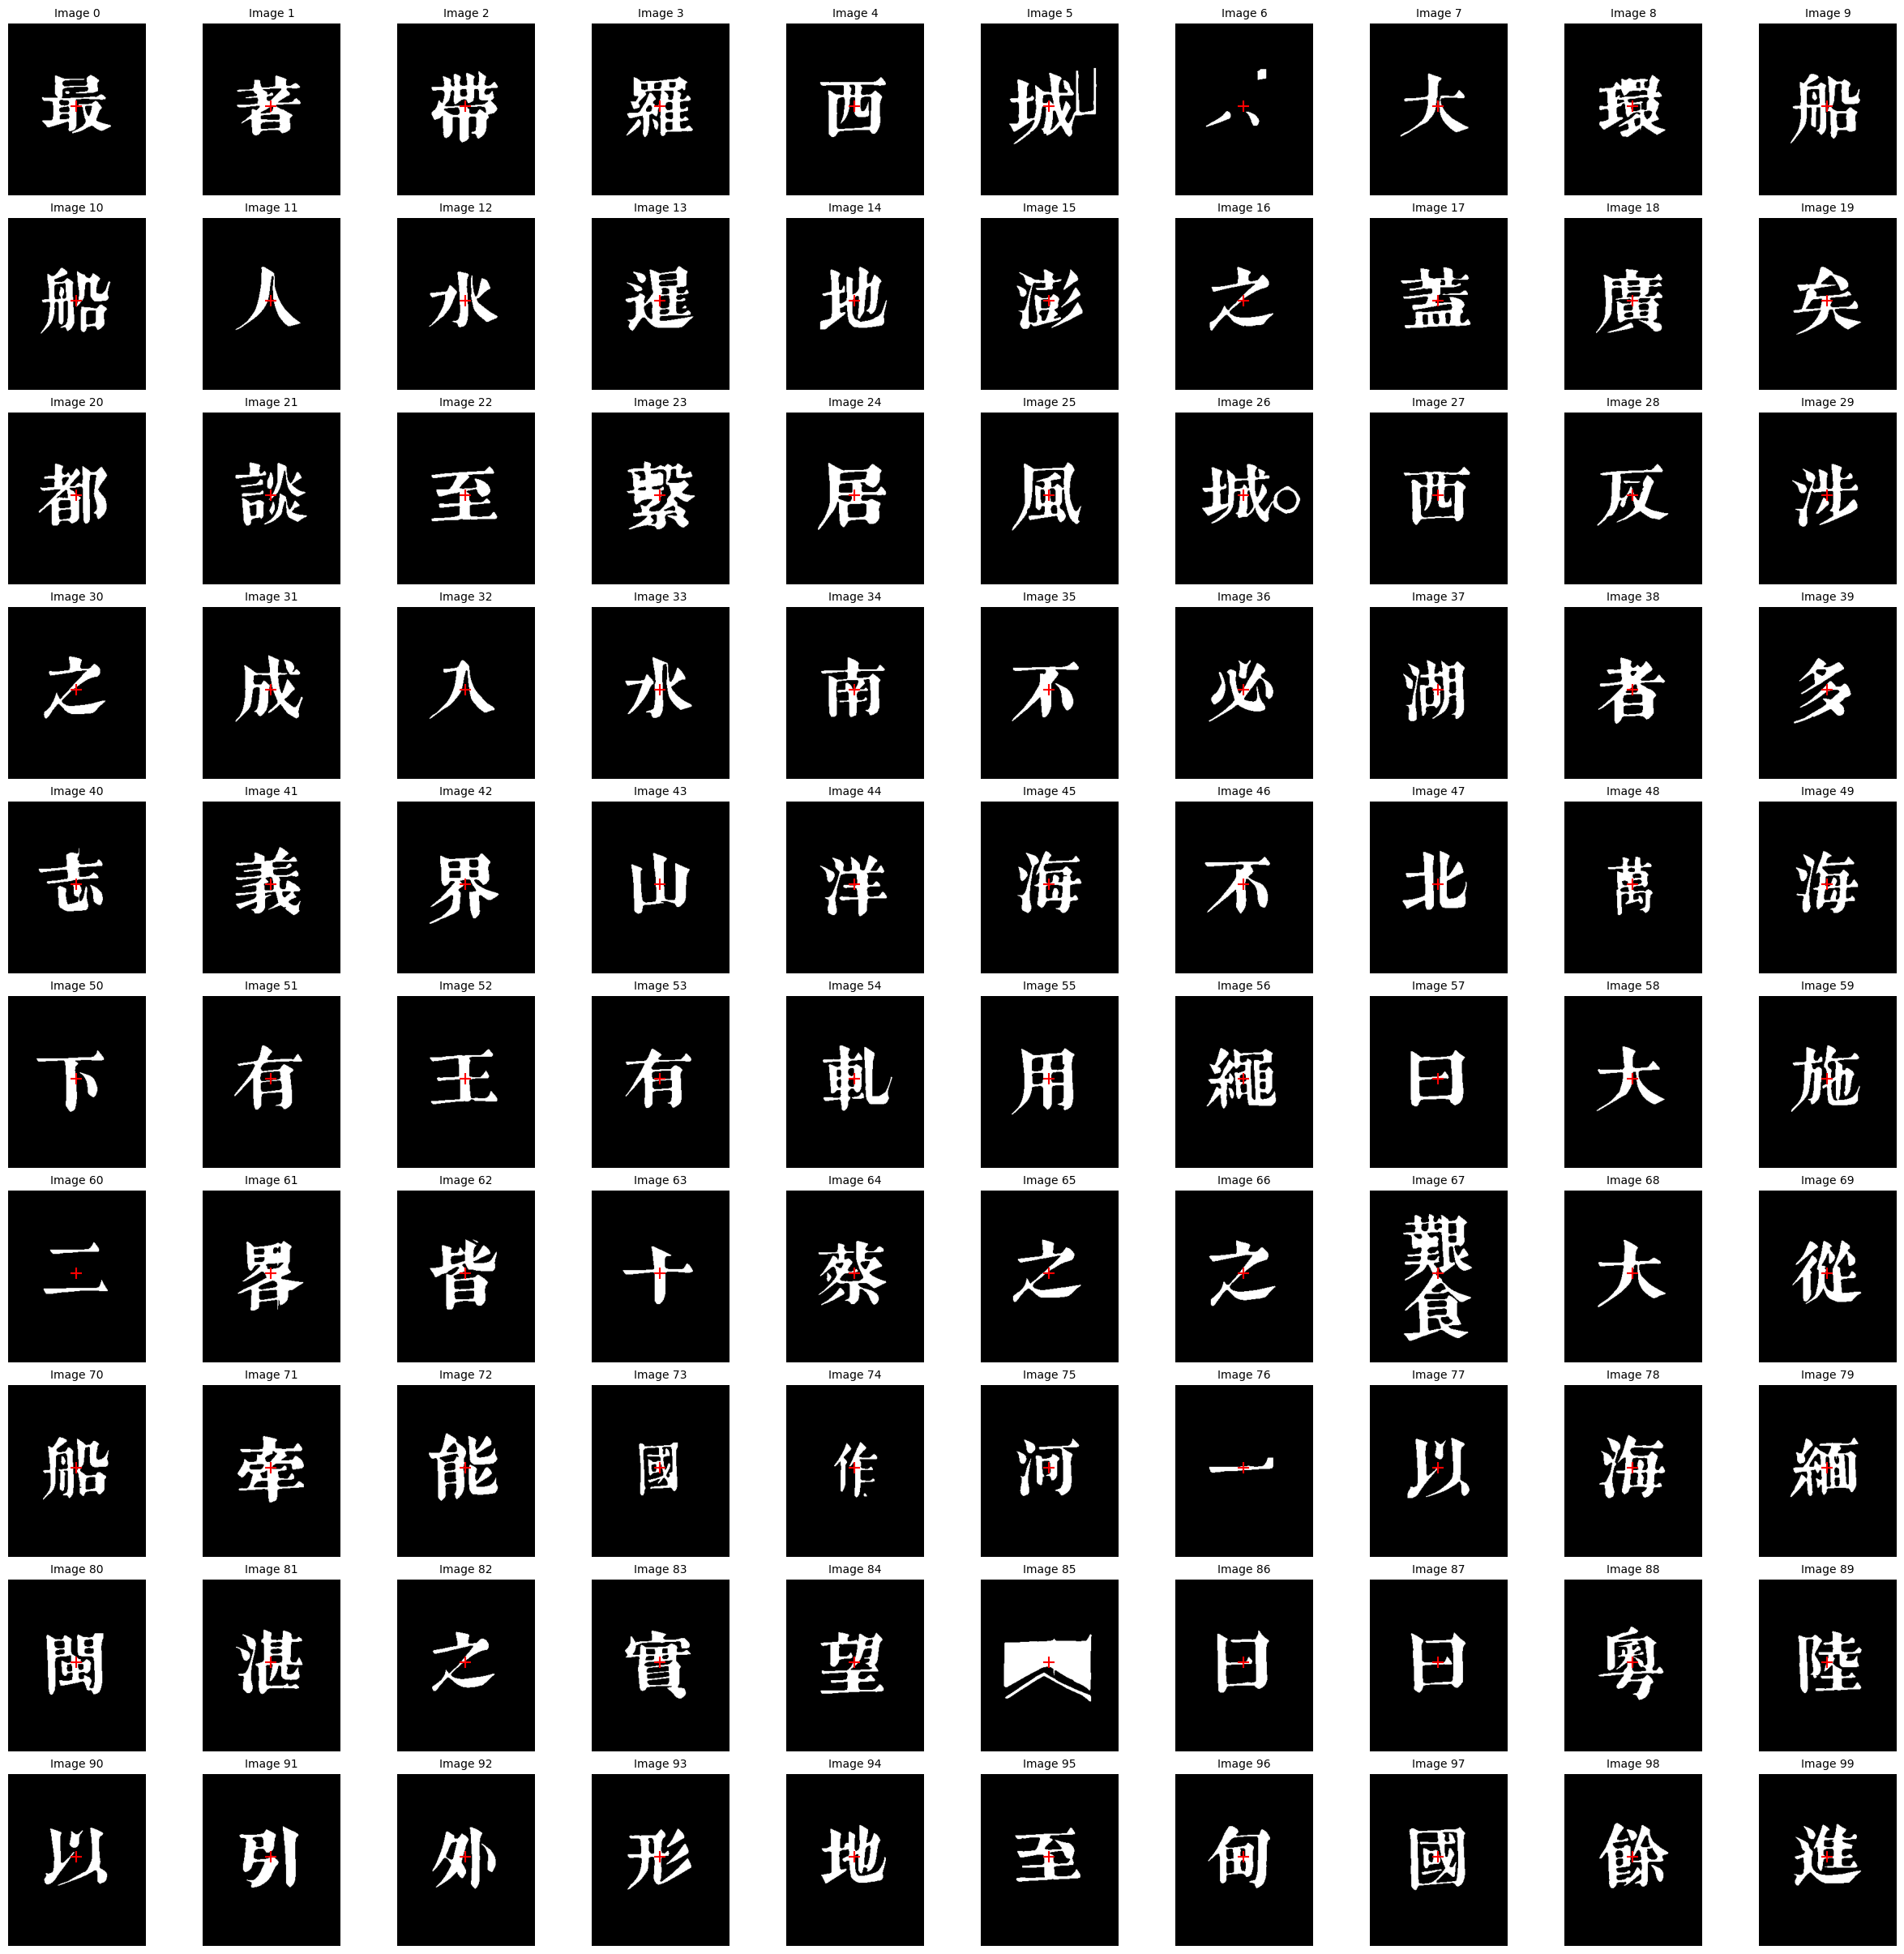

In [9]:
from src.patch_processing.normalization import compute_moment
from src.patch_processing import filter_binary_patch
from torch.utils.data import Dataset


class Renderer(Dataset):
    """Renders SVG images centered on their barycenters."""
    
    def __init__(
        self,
        svg_imgs,
        min_size_black,
        min_size_white,
        scale,
        bin_thresh=128,
        dpi=64,
        tqdm=True,
        pad_to_multiple=None
    ):
        self.svg_imgs = list(svg_imgs)
        self.min_size_black = min_size_black
        self.min_size_white = min_size_white
        self.scale = scale
        self.bin_thresh = bin_thresh
        self.dpi = dpi
        self.use_tqdm = tqdm
        self.pad_to_multiple = pad_to_multiple
        
        # Precompute canvas dimensions
        self._precompute_canvas()

        print(f'Canvas dimensions: w={self.canvas_width}, h={self.canvas_height}, cx={self.center_x}, cy={self.center_y}')
    
    def _precompute_canvas(self):
        """Compute canvas dimensions and barycenters once."""
        from tqdm import tqdm
        
        shapes, barycenters = self.compute_barycenters(svg_imgs)
        extents = self.compute_extents(shapes, barycenters)
        self.canvas_dims = self.compute_canvas_dims(extents)
        self.barycenters = barycenters
        
        self.canvas_width, self.canvas_height, self.center_x, self.center_y = self.canvas_dims
    
    def filter_images(self, svg_imgs):
        """Returns an iterator of filtered images."""
        from tqdm import tqdm
        
        it = tqdm(svg_imgs, desc="Rendering", unit="img") if self.use_tqdm else svg_imgs

        for svg_object in it:
            svg_rendered = svg_object.render(
                dpi=self.dpi, 
                output_format='L', 
                scale=self.scale,
                output_size=None
            )
            
            binary_svg = svg_rendered < self.bin_thresh
            
            filtered = filter_binary_patch(
                binary_svg, 
                min_size_black=self.min_size_black, 
                min_size_white=self.min_size_white, 
            )
            
            yield filtered

    def compute_barycenters(self, svg_imgs):
        barycenters = []
        shapes = []

        for filtered in self.filter_images(svg_imgs):
            m00 = compute_moment(filtered, 0, 0)
            if m00 == 0:
                cy, cx = filtered.shape[0] // 2, filtered.shape[1] // 2
            else:
                cy = compute_moment(filtered, 1, 0) / m00
                cx = compute_moment(filtered, 0, 1) / m00
            
            h, w = filtered.shape
            cy_pixel = (cy + 1) * (h - 1) / 2
            cx_pixel = (cx + 1) * (w - 1) / 2

            barycenters.append((cy_pixel, cx_pixel))
            shapes.append((h, w))

        return shapes, barycenters

    def compute_extents(self, shapes, barycenters):
        extents = []
        for (h, w), (cy, cx) in zip(shapes, barycenters):
            left = cx
            right = w - cx
            top = cy
            bottom = h - cy
            
            extents.append({
                'left': left,
                'right': right,
                'top': top,
                'bottom': bottom
            })
        return extents

    def _round_up_to_multiple(self, value, multiple):
        if multiple is None or multiple <= 1:
            return value
        return int(np.ceil(value / multiple) * multiple)

    def compute_canvas_dims(self, extents):
        max_left = max(e['left'] for e in extents)
        max_right = max(e['right'] for e in extents)
        max_top = max(e['top'] for e in extents)
        max_bottom = max(e['bottom'] for e in extents)
        
        canvas_width = int(np.ceil(max_left)) + int(np.ceil(max_right))
        canvas_height = int(np.ceil(max_top)) + int(np.ceil(max_bottom))

        if self.pad_to_multiple is not None and self.pad_to_multiple > 1:
            new_width = self._round_up_to_multiple(canvas_width, self.pad_to_multiple)
            new_height = self._round_up_to_multiple(canvas_height, self.pad_to_multiple)
            
            pad_x = new_width - canvas_width
            pad_y = new_height - canvas_height
            
            pad_left = pad_x // 2
            pad_top = pad_y // 2
            
            canvas_width = new_width
            canvas_height = new_height
        else:
            pad_left = 0
            pad_top = 0

        center_x = int(np.ceil(max_left)) + pad_left
        center_y = int(np.ceil(max_top)) + pad_top
        
        return canvas_width, canvas_height, center_x, center_y
    
    def __len__(self):
        return len(self.svg_imgs)
    
    def __getitem__(self, idx):
        """Get a single rendered image by index."""
        svg_object = self.svg_imgs[idx]
        
        # Render and filter
        svg_rendered = svg_object.render(
            dpi=self.dpi, 
            output_format='L', 
            scale=self.scale,
            output_size=None
        )
        
        binary_svg = svg_rendered < self.bin_thresh
        
        filtered = filter_binary_patch(
            binary_svg, 
            min_size_black=self.min_size_black, 
            min_size_white=self.min_size_white, 
        )
        
        # Paste on canvas
        cy, cx = self.barycenters[idx]
        h, w = filtered.shape
        start_y = int(np.round(self.center_y - cy))
        start_x = int(np.round(self.center_x - cx))
        
        canvas_img = np.zeros((self.canvas_height, self.canvas_width))
        canvas_img[start_y:start_y+h, start_x:start_x+w] = filtered
        
        # Convert to tensor
        return torch.from_numpy(canvas_img).float()


# Usage
dpi = 256
scale = 1
min_size_black = 75 * scale**2
min_size_white = 20 * scale**2

dataset = Renderer(
    svg_imgs=svg_imgs,
    min_size_black=min_size_black,
    min_size_white=min_size_white,
    scale=scale,
    bin_thresh=128,
    dpi=dpi,
    pad_to_multiple=32
)

# Access canvas dimensions
canvas_width = dataset.canvas_width
canvas_height = dataset.canvas_height
center_x = dataset.center_x
center_y = dataset.center_y

print(f"Canvas size: {canvas_width}×{canvas_height} pixels")

# Create DataLoader for batching
from torch.utils.data import DataLoader

dataloader = DataLoader(
    dataset,
    batch_size=256,
    shuffle=False,
    num_workers=0,  # Set to >0 if rendering is CPU-intensive
    pin_memory=True
)


# Or get individual images
N = 10
fig, axes = plt.subplots(N, N, figsize=(24, 24), constrained_layout=True)

for i, ax in enumerate(axes.flat):
    ax.axis('off')
    
    img = dataset[i].numpy()  # Get i-th image
    ax.imshow(img, cmap='gray', vmin=0, vmax=1, aspect='equal')
    ax.set_title(f'Image {i}', fontsize=10)
    
    ax.plot(center_x, center_y, 'r+', markersize=10, markeredgewidth=1.5)

plt.show()


## Computing the HOG descriptor

We now explain how we compute the HOG descriptor to match the different patches to characters.

The computation is done as follows:

1. Preprocessing step

The images on which we wish to compute the descriptors are preprocessed.
It is possible to compute the descriptors on either grayscale images or multi-channel images. We use grayscale conversion.
We also resize the images to a fixed size.

2. Computing the gradients

There are several ways to compute the gradients. We first begin by using a gaussian filter to smooth the image.
Then, we apply a separable convolution based on cv2.getDerivKernels to compute the image gradients. The two components of this separable convolutions are:
- A smoothing operator on one axis
- It's derivative on the other axis

This is justified because of derivative operations on convolution products.:

$$\frac{\partial}{\partial x}(I * G) = I * \frac{\partial G}{\partial x}$$

For a 2D Gaussian $G(x,y) = G_x(x) \cdot G_y(y)$, the x-gradient becomes:

$$
\frac{\partial}{\partial x}(I * G) = I * \left(\frac{\partial G_x}{\partial x} \otimes G_y\right)
$$

where $\otimes$ denotes separable convolution: first convolve rows with $G_y$ (smooth), then columns with $\frac{\partial G_x}{\partial x}$ (differentiate).

3. Histogram Computation

We begin by computing:
- The orientation of the gradients in the image: $\theta = \text{arctan2}(dx, dy)$
- Their magnitude: $M = \sqrt{{dx}^2 + {dy}^2}$

We rearrange these arrays of shape $(H, W)$ to $(\text{Nh}, \text{Nw}, h, w)$, with Nh and Nw the number of rows / cols of cells, $h$ and $w$ their height and width

We will use trilinear interpolation to compute the histograms.
For each pixel $u$ of the cell, we compute the two bins the cell should contribute to:

$$i_1 = \lfloor\theta_u \cdot N_{\text{bins}}\rfloor \quad ; \quad i_2 = i_1 + 1$$

The contribution weights for angular interpolation are:
$$w_2 = \theta_u \cdot N_{\text{bins}} - i_1 \quad ; \quad w_1 = 1 - w_2$$

Optionally, a Gaussian spatial weighting can be applied (used in SIFT, but not in standard HOG):
$$w_{\text{spatial}}(x, y) = \exp\left(-\frac{x_n^2 + y_n^2}{2\sigma^2}\right)$$
where $(x_n, y_n) \in [-1, 1]^2$ are normalized coordinates from the cell center.

Each pixel contributes to the histogram:
$$H[i_1] \mathrel{+}= M_u \cdot w_1 \cdot w_{\text{spatial}} \quad ; \quad H[i_2] \mathrel{+}= M_u \cdot w_2 \cdot w_{\text{spatial}}$$

4. Normalization

As in SIFT, the descriptors can be optionally normalized.
We can normalize them:
- At cell-level: normalize each histogram to be unit norm (as done in SIFT)
- At patch-level: normalize the vector of concatenated

[This paper](https://www.ipol.im/pub/art/2014/82/article.pdf), Anatomy of the SIFT method, states that cell-level normalization can help with lightning changes.
We don't have such lightning changes, and have small cells. We therefore prefeer to use patch-level normalization. 

As in SIFT, we clip the values of the descriptors to be in the $[-0.2, 0.2]$ range, before re-normalizing the descriptors.

In [10]:
hog_params = HOGParameters(
    device          = "cuda",
    C               = 1,                        # Use grayscale images
    partial_output  = False,                    # Also output the resized images, their gradient orientation and magnitude
    method          = 'gaussian',               # Use gaussian smoothing to compute the gradients
    grdt_sigma      = 5,                      # Std of the smoothing
    ksize_factor    = 6,                        # Size of the smoothing kernel = factor * std
    cell_height     = 32,                       # Size of the cells to compute the histograms
    cell_width      = 16,
    num_bins        = 8,                        # Number of bins
    threshold       = 0.2,                      # Clip the values of the descriptor
    normalize       = 'patch'                   # Normalize at patch-level. SIFT uses cell-level descriptor normalization
)

from src.character_linking.hog import HOG


first_batch = next(iter(dataloader))


hog = HOG(hog_params)
hogOutput = hog(first_batch.unsqueeze(1).to(dtype=torch.float32, device='cuda'))

histograms_first_batch = hogOutput.histograms[:, 0]


fft convolution ; scipy 

Visualizing patch 149
Grid: 10 x 16 cells, each with 8 orientation bins
Cell size: 32 x 16 pixels


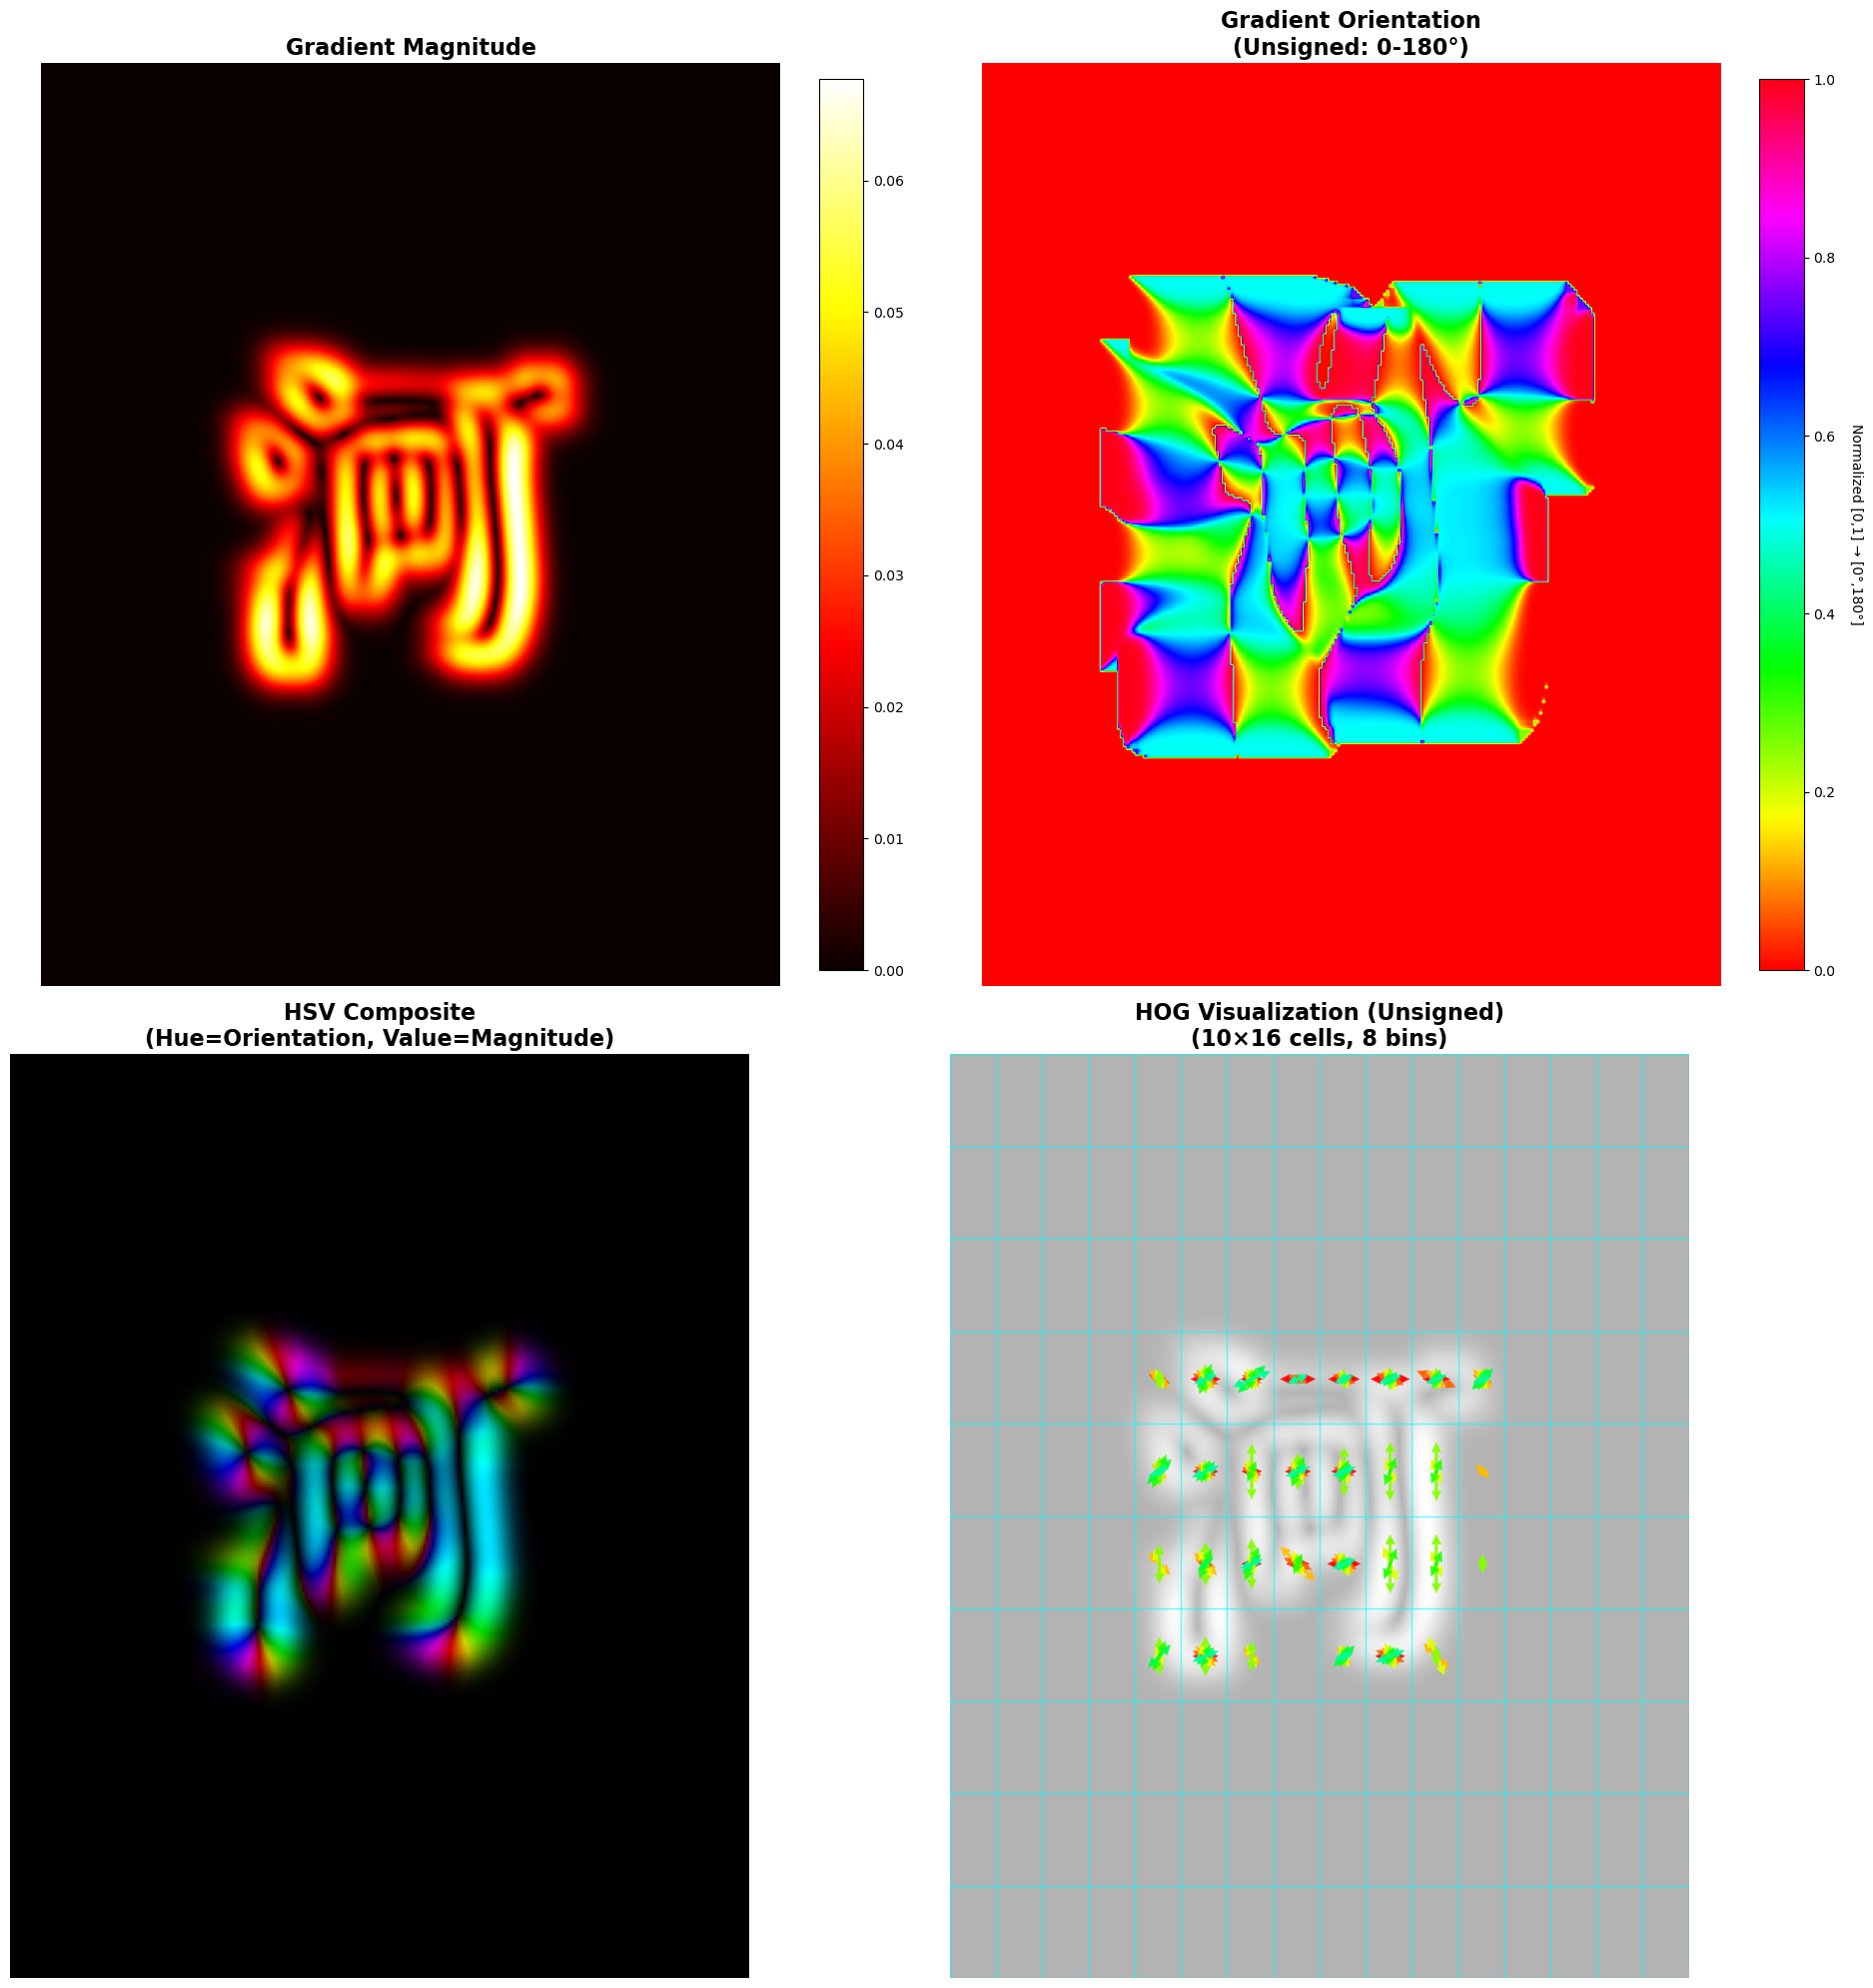


Histogram Statistics:
  Min: 0.0000
  Max: 0.2457
  Mean: 0.0079
  L2 norm: 1.0000


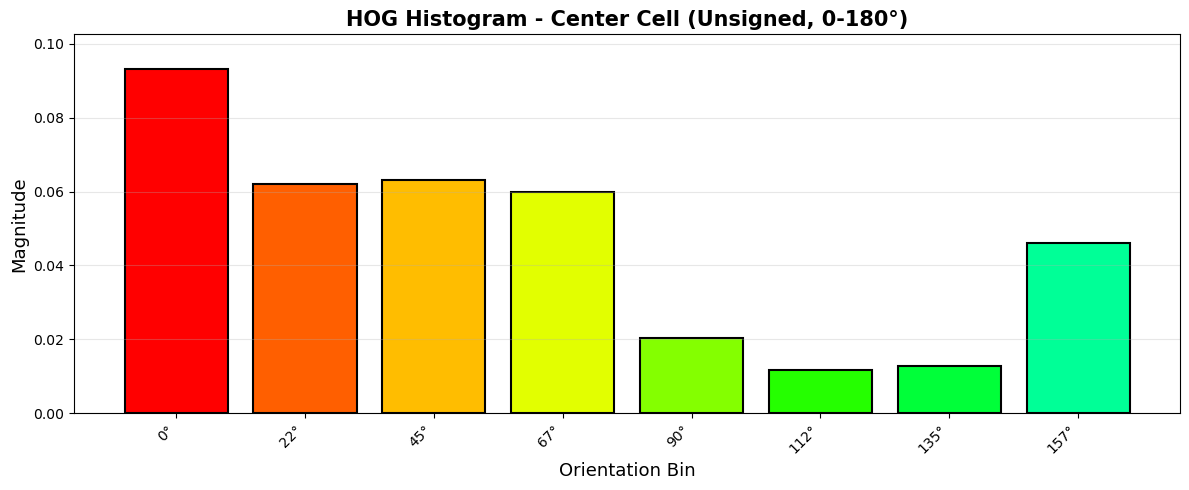

In [11]:
i = np.random.randint(0, len(histograms_first_batch))
# i = 98
# i = 220

visualize_hog(hog_params, histograms_first_batch, first_batch, hogOutput, i)

In [12]:
hog_params = HOGParameters(
    device          = "cuda",
    C               = 1,                        # Use grayscale images
    partial_output  = False,                    # Also output the resized images, their gradient orientation and magnitude
    method          = 'gaussian',               # Use gaussian smoothing to compute the gradients
    grdt_sigma      = 5,                      # Std of the smoothing
    ksize_factor    = 6,                        # Size of the smoothing kernel = factor * std
    cell_height     = 16,                       # Size of the cells to compute the histograms
    cell_width      = 16,
    num_bins        = 8,                        # Number of bins
    threshold       = 0.2,                      # Clip the values of the descriptor
    normalize       = 'patch'                   # Normalize at patch-level. SIFT uses cell-level descriptor normalization
)

from src.character_linking.hog import HOG


first_batch = next(iter(dataloader))


hog = HOG(hog_params)

# Get the total number of samples and histogram shape
total_samples = len(dataloader.dataset)
sample_output = hog(first_batch[:1].unsqueeze(1).to(dtype=torch.float32, device='cuda'))
histogram_shape = sample_output.histograms[0, 0].shape

histograms = torch.zeros((total_samples, *histogram_shape), device='cuda')

# Fill progressively
start_idx = 0
for batch in tqdm(dataloader):
    hogOutput = hog(batch.unsqueeze(1).to(dtype=torch.float32, device='cuda'))
    histogram_batch = hogOutput.histograms[:, 0]
    
    batch_size = histogram_batch.shape[0]
    histograms[start_idx:start_idx + batch_size] = histogram_batch
    start_idx += batch_size


100%|██████████| 55/55 [01:41<00:00,  1.85s/it]


**Let's look at a t-sne plot of the histograms to see if we can observe some clusters:**

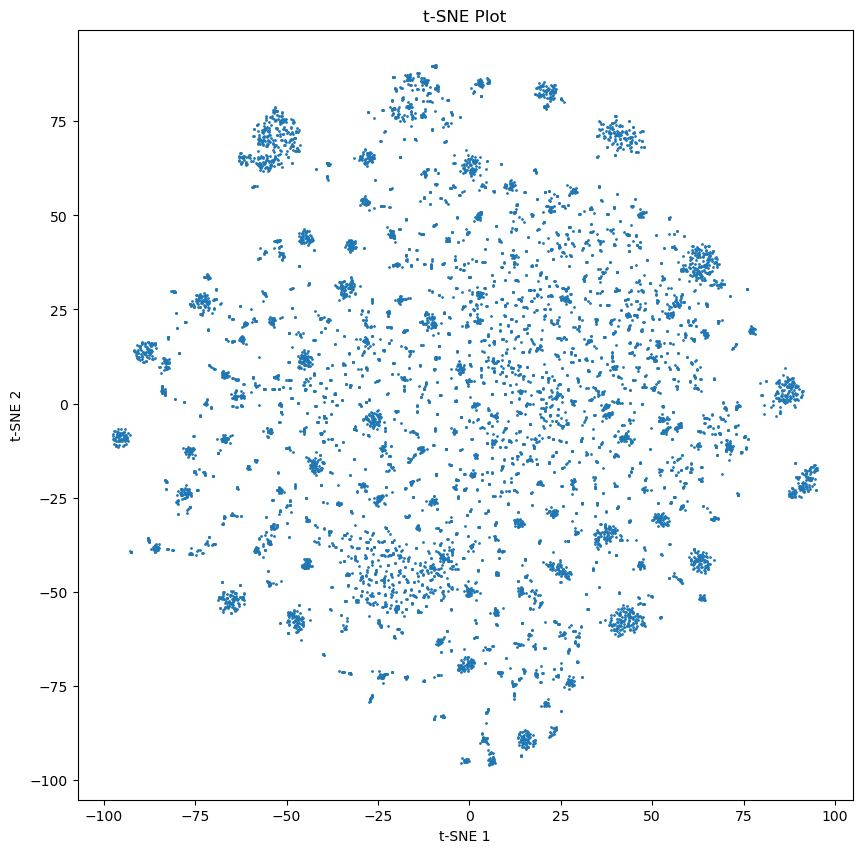

In [13]:
X = histograms.reshape(histograms.shape[0], -1)[:10000].cpu().numpy()
X.shape

from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
X_embedded = tsne.fit_transform(X)

plt.figure(figsize=(10,10))
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], s=1)
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title('t-SNE Plot')
plt.show()


## Computing the matches

Now that we have the descriptors, we will use Rabin's et al. methodology to match the SIFT descriptors. We will explain, step by step, how it works:

## Statistical test for descriptor matching

**Based on [this paper](https://hal.science/hal-00168285/document) and ideas by Aitor Artola**

### Framework and notation

Let $a^i = (a^i_1, \ldots, a^i_M)$ and $b = (b_1, \ldots, b_M)$ be two descriptor vectors with $M$ vector components (e.g., histograms).

**Global dissimilarity measure**:
$$D(a^i, b) = \sum_{m=1}^{M} d(a^i_m, b_m)$$
where $d(\cdot, \cdot)$ is a dissimilarity measure between components (Euclidean distance, Circular Earth Mover Distance, etc.).

### Null hypothesis

**$\mathcal{H}_0^i$**: The random variables $\{d(a^i_m, b_m)\}_{m=1}^M$ are mutually independent.

Under this hypothesis, each $d(a^i_m, b_m)$ is a random variable with density $p_m$, mean $\mu_m$, and variance $\sigma_m^2$.

### Probability under the null hypothesis

The probability that the global dissimilarity is below a threshold $\delta$ is:
$$\mathbb{P}\left(D(a^i, b) \leq \delta \mid \mathcal{H}_0^i\right) = \mathbb{P}\left(\sum_{m=1}^{M} d(a^i_m, b_m) \leq \delta\right)$$

This probability corresponds to the cumulative distribution function of the sum of independent random variables:
$$\mathbb{P}\left(D(a^i, b) \leq \delta \mid \mathcal{H}_0^i\right) = (p_1 * p_2 * \cdots * p_M)(\delta)$$
where $*$ denotes convolution.

### Normal approximation (CLT)

**Theorem (Lindeberg-Feller CLT)**: Let $X_m = d(a^i_m, b_m)$ be independent random variables with $\mathbb{E}[X_m] = \mu_m$ and $\text{Var}(X_m) = \sigma_m^2$. Define:
$$S_M = \sum_{m=1}^M X_m, \quad s_M^2 = \sum_{m=1}^M \sigma_m^2$$

Under appropriate regularity conditions (Lindeberg condition and Feller condition), we have:
$$\frac{S_M - \mathbb{E}[S_M]}{s_M} = \frac{\sum_{m=1}^M (X_m - \mu_m)}{s_M} \xrightarrow[\text{dist}]{M \to \infty} \mathcal{N}(0, 1)$$

**In practice**, for fixed and sufficiently large $M$, under $\mathcal{H}_0^i$:
$$D(a^i, b) \approx \mathcal{N}\left(\mu_{\text{tot}}, \sigma_{\text{tot}}^2\right)$$
with $\mu_{\text{tot}} = \sum_{m=1}^M \mu_m$ and $\sigma_{\text{tot}}^2 = \sum_{m=1}^M \sigma_m^2$ (finite quantities).

This approximation is justified when:
1. The $d(a^i_m, b_m)$ are independent
2. The Feller condition is verified
3. $M$ is large enough for the normal approximation to be accurate

### Statistical test

We compute the $p$-value:
$$p\text{-value} = \mathbb{P}\left(D(a^i, b) \leq \delta_{\text{obs}} \mid \mathcal{H}_0^i\right) \approx \Phi\left(\frac{\delta_{\text{obs}} - \mu_{\text{tot}}}{\sigma_{\text{tot}}}\right)$$
where $\Phi$ is the cumulative distribution function of the standard normal distribution.

We reject $\mathcal{H}_0^i$ (the descriptors do not match) if this $p$-value is too low. When comparing $N_Q$ query descriptors against $N_C$ candidates, the matching threshold for a given $\varepsilon > 0$ is obtained by finding the largest $\delta$ such that:
$$\Phi\left(\frac{\delta - \mu_{\text{tot}}}{\sigma_{\text{tot}}}\right) \leq \frac{\varepsilon}{N_Q N_C}$$

Since $\Phi$ is monotonically increasing, this gives:
$$\frac{\delta_i(\varepsilon) - \mu_{\text{tot}}}{\sigma_{\text{tot}}} = \Phi^{-1}\left(\frac{\varepsilon}{N_Q N_C}\right)$$

Therefore:
$$\delta_i(\varepsilon) = \mu_{\text{tot}} + \sigma_{\text{tot}} \cdot \Phi^{-1}\left(\frac{\varepsilon}{N_Q N_C}\right)$$

A match between $a^i$ and $b^j$ is **$\varepsilon$-meaningful** if $D(a^i, b^j) \leq \delta_i(\varepsilon)$. Under $\mathcal{H}_0^i$, the expected number of $\varepsilon$-meaningful matches is bounded by $\varepsilon$.


# Dissimilarity measures

In practice, the dissmiliraties $d(\cdot, \cdot)$ between two components $a^i_m$ and $b_m$ are implemented as either:
- Euclidean distance
- Circular Earth Mover Distance (CEMD)

The CEMD is a distance introduced in the same paper, and is an adaption of the Earth Mover Distance for circular histograms. We describe it briefly in the following section:

## Circular Earth Mover Distance (CEMD)

**Based on [this paper](https://hal.science/hal-00168285/document)**.

The Earth Mover Distance is the Wasserstein-1 metric, which compares two probability measures $\mu$ and $\nu$. In the general case, given a metric space $(M, c)$, it is formulated as $W_1(\mu, \nu) = \inf \limits_{\gamma \in \Gamma(\mu, \nu)} \mathbb{E}_{(x,y)\sim\gamma}\left[ c(x, y)\right]$, where $\Gamma(\mu, \nu)$ is the set of all couplings between $\mu$ and $\nu$. For two discrete histograms $f$ and $g$ with $N$ bins, their EMD is defined as $\text{EMD}(f, g) = \min_{\alpha_{i, j} \in \mathcal{M}} \sum \limits_{i=1}^N \sum \limits_{j=1}^N \alpha_{i,j} c(i, j)$, with $\mathcal{M}$ the set of all couplings between $f$ and $g$.

For circular histograms, we use:
$$c(i,j) = \frac{1}{N} \min(|i-j|, N - |i-j|), \quad \forall (i,j) \in \{1, \ldots N\}^2.$$

When the distance is $c(i, j) = \frac{1}{N} | i-j |$ (non-circular case), it is well-known that EMD equals the $\ell_1$ distance between cumulative histograms: $\text{EMD}(f, g) = \|F - G\|_1 = \frac{1}{N}\sum_{i=1}^N |F[i] - G[i]|$, where $F[i] = \sum_{j=1}^i f[j]$ and $G[i] = \sum_{j=1}^i g[j]$.

Rabin et al. proved that for circular histograms with the circular ground distance, the Circular Earth Mover's Distance (CEMD) can be efficiently computed as:

$$\text{CEMD}(f, g) = \min_{k \in \{1,\ldots N\}} \|F_k - G_k\|_1$$

where $F_k$ and $G_k$ are cumulative histograms of $f$ and $g$ starting at the $k$-th bin.


**We now compute matches and their negative log false alarm rates (NLFA) using the HOG descriptor and Euclidean distance within the a contrario framework. The NLFA represents the negative log of the p-value: high values indicate matches that are statistically unlikely under the independence hypothesis.**

In [14]:
eps = 0.1

featureMatching_params = featureMatchingParameters(
    metric          = "L2",                             # The dissimilarity measure - could have been 'CEMD'
    epsilon         = eps,                              # Expected number of false matches
    reciprocal_only = True,                             # not 
    partial_output  = False,
    distribution='normal'
)
feature_matcher = featureMatching(featureMatching_params)

matches, nlfa, dissimilarities = feature_matcher.match(histograms, histograms)

del dissimilarities # free the memory

Batch size :  1


100%|██████████| 13887/13887 [03:24<00:00, 67.75it/s]


**We only keep the reciprocal matches: the nlfa should be above a threshold in both directions.**

In [15]:
nlfa_threshold = feature_matcher.nlfa_theshold(histograms, histograms)

reciprocal = torch.logical_and(nlfa >= nlfa_threshold, nlfa.T >= nlfa_threshold)
matches = torch.nonzero(reciprocal, as_tuple=False)
matches = matches[matches[:,0] != matches[:, 1]]
del reciprocal # free the memory

print('Number of matches :', len(matches))
print('Number of patches:', len(histograms))
print(f'Average number of matches per patch: {len(matches) / len(histograms):.1f}')

Number of matches : 854430
Number of patches: 13887
Average number of matches per patch: 61.5


**Let's show the average number of matches per image as a function of the nlfa threshold**:

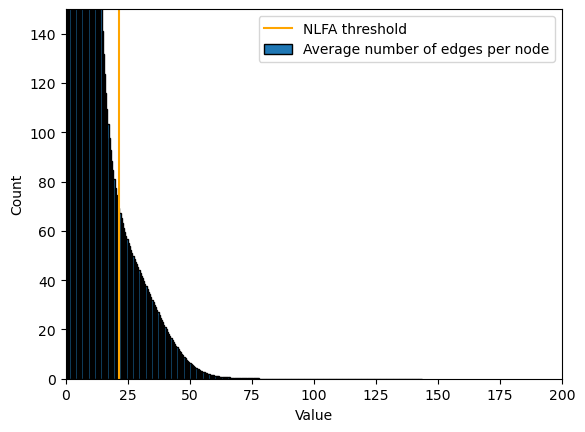

In [16]:
nlfa_threshold = -(np.log(eps) - 2 * np.log(len(histograms)))
hist, bin_edges = torch.histogram(nlfa.reshape(-1).cpu(), bins=300)
cumhist = torch.flip(hist, dims=[0]).cumsum(0).flip(0)
avrg_neighbors = cumhist / len(histograms)
# Calculate bin centers and widths

bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
bin_widths = bin_edges[1:] - bin_edges[:-1]

# Create bar plot
plt.bar(bin_centers, avrg_neighbors, width=bin_widths, edgecolor='black', align='center', label="Average number of edges per node")
plt.axvline(nlfa_threshold, c='orange', label='NLFA threshold')
plt.xlabel('Value')
plt.ylabel('Count')
plt.ylim(0,150)
plt.xlim(0,200)
plt.legend()
plt.show()


<>:30: SyntaxWarning: invalid escape sequence '\m'
<>:30: SyntaxWarning: invalid escape sequence '\s'
<>:30: SyntaxWarning: invalid escape sequence '\m'
<>:30: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_29632/2371014867.py:30: SyntaxWarning: invalid escape sequence '\m'
  ax.plot(x, gaussian, 'r-', linewidth=2, label=f'Gaussian fit\n$\mu$={mu_tot:.3f}, $\sigma$={np.sqrt(var_tot):.3f}')
/tmp/ipykernel_29632/2371014867.py:30: SyntaxWarning: invalid escape sequence '\s'
  ax.plot(x, gaussian, 'r-', linewidth=2, label=f'Gaussian fit\n$\mu$={mu_tot:.3f}, $\sigma$={np.sqrt(var_tot):.3f}')


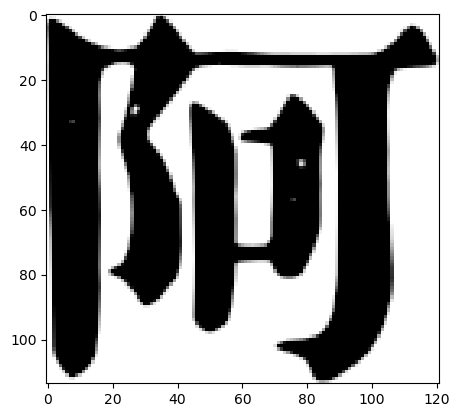

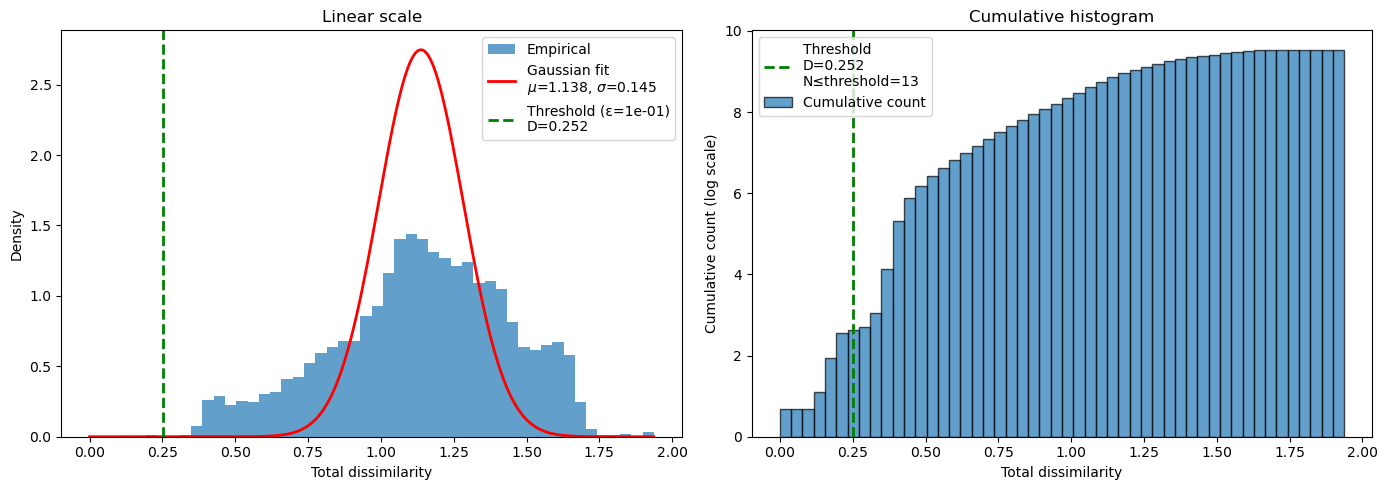

In [17]:
# Statistics for the dissimilarities of one random histogram $(a_1, ..., a_M)$ against all others.
N, N_cells, N_bins = histograms.shape
NBINS = 50


# patches = images.squeeze(1).cpu()

idx_start = np.random.randint(N)
queries = histograms[idx_start:idx_start+1]
dissim = feature_matcher.compute_dissimilarities(queries, histograms)


# show the distribution

total_dissim = dissim.sum(-1).reshape(-1).cpu()
mu_tot   = dissim.mean(dim=1).sum(dim=1).item()
var_tot  = dissim.var(dim=1).sum(dim=1).item()*2

plt.imshow(patches_df['svg'][idx_start].render(), cmap='gray')
plt.show()
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Original plot
ax = axes[0]
ax.hist(total_dissim.numpy(), bins=NBINS, density=True, alpha=0.7, label='Empirical')

# Add Gaussian overlay
x = np.linspace(total_dissim.min(), total_dissim.max(), 200)
gaussian = (1 / np.sqrt(2 * np.pi * var_tot)) * np.exp(-0.5 * ((x - mu_tot) / np.sqrt(var_tot))**2)
ax.plot(x, gaussian, 'r-', linewidth=2, label=f'Gaussian fit\n$\mu$={mu_tot:.3f}, $\sigma$={np.sqrt(var_tot):.3f}')

# Add dissimilarity threshold
eps = feature_matcher._params.epsilon
nlfa_threshold = -(np.log(eps) - 2 * np.log(len(histograms)))

# Convert NLFA threshold to dissimilarity threshold using inverse Gaussian CDF
from scipy.stats import norm
dissim_threshold = mu_tot + np.sqrt(var_tot) * norm.ppf(np.exp(-nlfa_threshold))

ax.axvline(dissim_threshold, color='g', linestyle='--', linewidth=2, 
            label=f'Threshold (ε={eps:.0e})\nD={dissim_threshold:.3f}')

ax.legend()
ax.set_xlabel('Total dissimilarity')
ax.set_ylabel('Density')
ax.set_title('Linear scale')

# Cumulative histogram (log scale) for tail visualization
ax = axes[1]
hist, bin_edges = torch.histogram(total_dissim, bins=NBINS)
cumhist = torch.log(1+hist.cumsum(0))
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
bin_widths = bin_edges[1:] - bin_edges[:-1]

# Count elements under threshold
n_under_threshold = (total_dissim <= dissim_threshold).sum().item()

ax.bar(bin_centers.numpy(), cumhist.numpy(), width=bin_widths.numpy(), 
       edgecolor='black', alpha=0.7, align='center', label='Cumulative count')
ax.axvline(dissim_threshold, color='g', linestyle='--', linewidth=2, 
           label=f'Threshold\nD={dissim_threshold:.3f}\nN≤threshold={n_under_threshold}')

ax.legend()
ax.set_xlabel('Total dissimilarity')
ax.set_ylabel('Cumulative count (log scale)')
ax.set_title('Cumulative histogram')

plt.tight_layout()
plt.show()

**Remark: Sometimes, the distribution does not seem gaussian at all This is very bad news as it is how we compute the threshold**

Showing 13 out of 13 elements under threshold (sorted by distance):


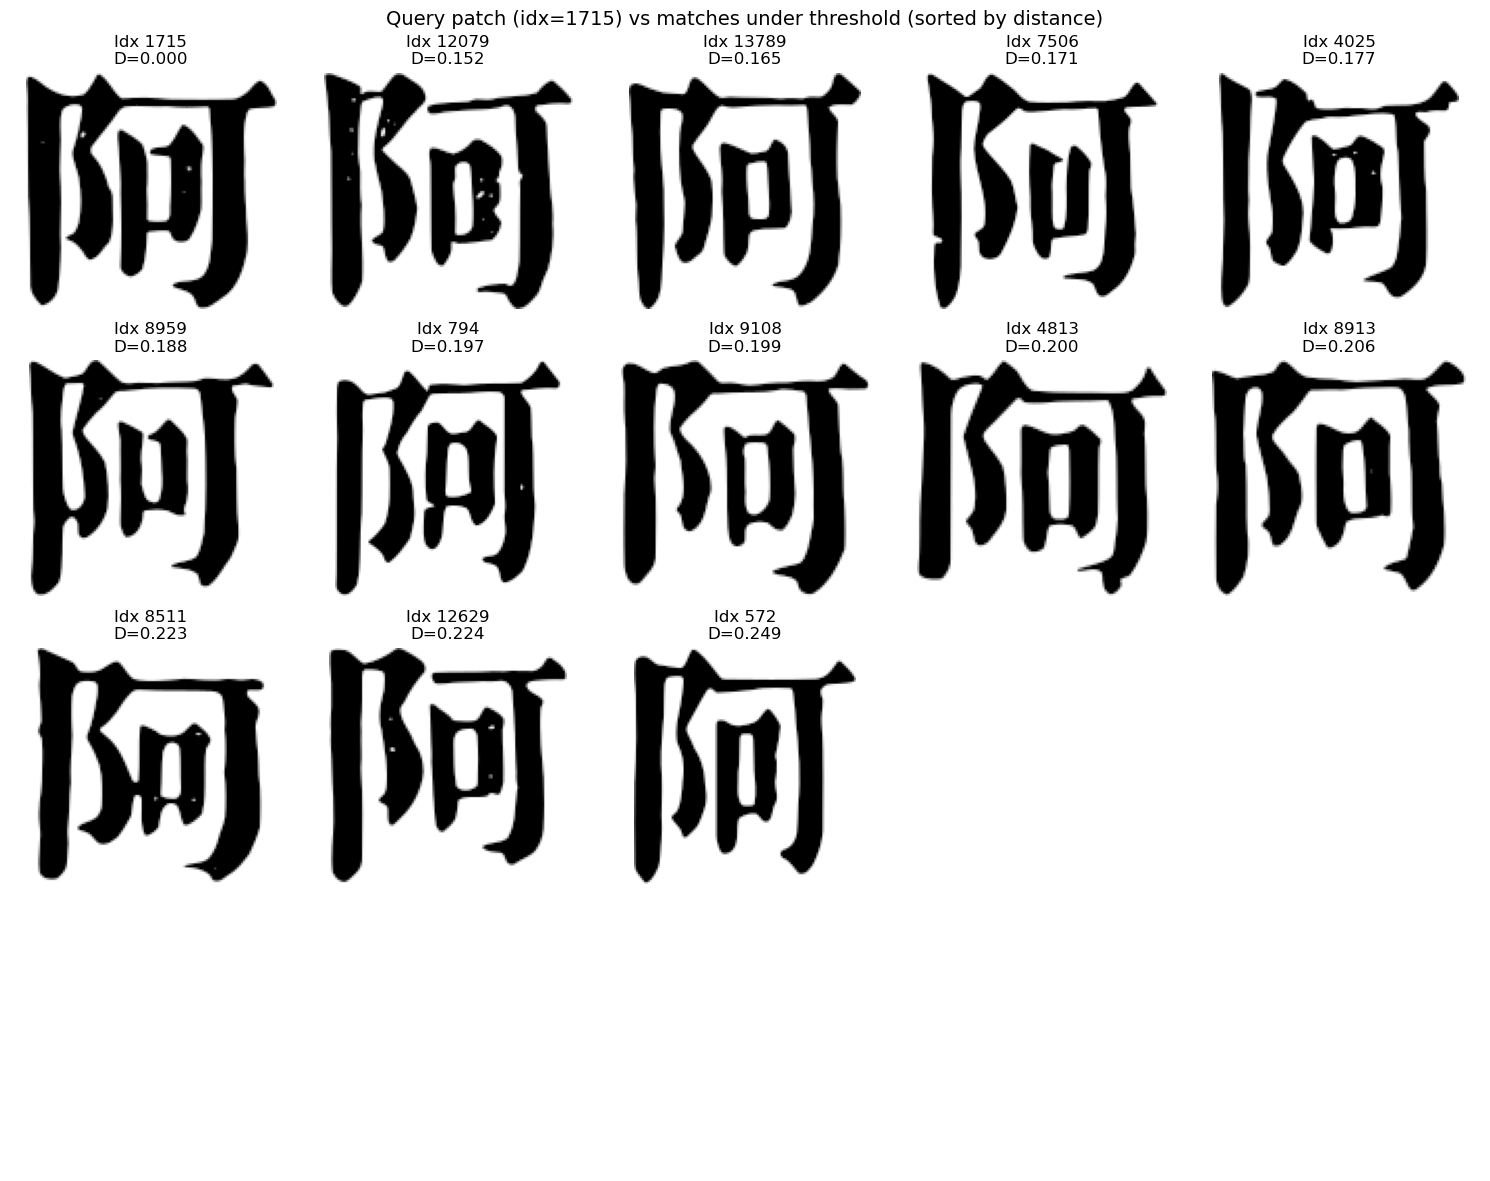

In [18]:
# Show elements under the threshold (limit to 20), sorted by distance
under_threshold_mask = total_dissim <= dissim_threshold
under_threshold_indices = torch.where(under_threshold_mask)[0]
under_threshold_dissim = total_dissim[under_threshold_mask]

# Sort by dissimilarity
sorted_indices = torch.argsort(under_threshold_dissim)
sorted_under_threshold_indices = under_threshold_indices[sorted_indices]
sorted_dissim_values = under_threshold_dissim[sorted_indices]

n_to_show = min(20, len(sorted_under_threshold_indices))

print(f"Showing {n_to_show} out of {len(sorted_under_threshold_indices)} elements under threshold (sorted by distance):")

fig, axes = plt.subplots(4, 5, figsize=(15, 12))
axes = axes.flatten()

for i in range(n_to_show):
    idx = sorted_under_threshold_indices[i].item()
    dissim_value = sorted_dissim_values[i].item()
    
    patch_img = patches_df['svg'][idx].render()
    axes[i].imshow(patch_img, cmap='gray')
    axes[i].set_title(f'Idx {idx}\nD={dissim_value:.3f}')
    axes[i].axis('off')

# Hide unused subplots
for i in range(n_to_show, 20):
    axes[i].axis('off')

plt.suptitle(f'Query patch (idx={idx_start}) vs matches under threshold (sorted by distance)', fontsize=14)
plt.tight_layout()
plt.show()

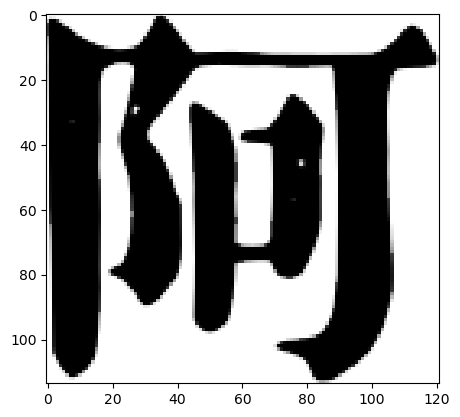

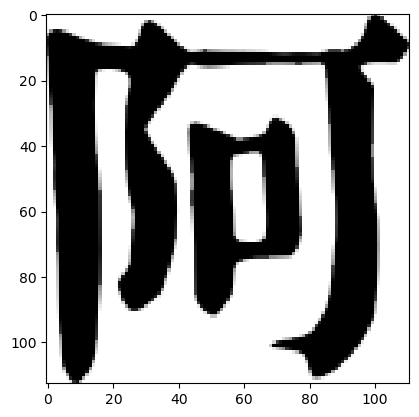

In [19]:
i1 = sorted_under_threshold_indices[0]
i2 = sorted_under_threshold_indices[2]
size = (64, 64)
# im1 = np.array(torch_to_pil(patches[i1].unsqueeze(0)).resize(size))
# im2 = np.array(torch_to_pil(patches[i2].unsqueeze(0)).resize(size))
im1 = patches_df['svg'][i1.item()].render()
im2 = patches_df['svg'][i2.item()].render()

im1[im1<100]=0
im2[im2<100]=0
plt.imshow(im1);plt.show()
plt.imshow(im2);plt.show()
dtype = torch.float32
im1 = torch.tensor(im1).to(device='cuda', dtype=dtype) / 255
im2 = torch.tensor(im2).to(device='cuda', dtype=dtype) / 255

In [20]:
from IPython.display import display, Markdown
from hydra.utils import instantiate
from omegaconf import OmegaConf
os.environ["HYDRA_FULL_ERROR"] = "1"

cfg = compose(config_name="inverse_compositional")
ic = instantiate(cfg)
# Display the model configuration
display(Markdown(f"```yaml\n{OmegaConf.to_yaml(cfg)}\n```"))

```yaml
_target_: src.registration.multiscale_registration.MultiscaleIC
singleScaleIC:
  _target_: src.registration.single_scale.InverseCompositional
  transform_type: homography
  gradient_method:
    _target_: src.registration.gradients.Gradients
    method: farid5
    C: 1
    device: cpu
  error_function: lorentzian
  delta: 5
  epsilon: 0.001
  max_iter: 120
  lambda_init: 80.0
  lambda_min: 5.0
  lambda_decay: 0.9
gaussianPyramid:
  _target_: src.registration.gaussian_pyramid.GaussianPyramid
  eta: 0.5
  sigma_0: 0.6
  ksize_factor: 8
  min_size: 32

```

In [ ]:
im1.shape, im2.shape

(torch.Size([120, 120, 4]), torch.Size([124, 125, 4]))

In [37]:
# %%timeit
T = ic.run(I1=im1.cpu(), I2=im2.cpu())
warped = T.warp(im2.unsqueeze(0).unsqueeze(0))
mask = T.visibility_mask(im1.shape[0], im1.shape[1], delta=0)
warped[0,0][~mask] = 1

/home/mathis/Bureau/OCRProject/src/registration/single_scale.py:26: SyntaxWarning: invalid escape sequence '\l'
  """


RuntimeError: The size of tensor a (117) must match the size of tensor b (122) at non-singleton dimension 2

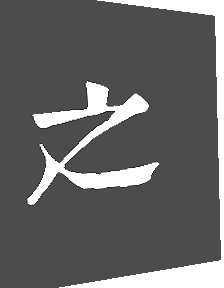

In [ ]:
torch_to_pil(warped.squeeze(0))

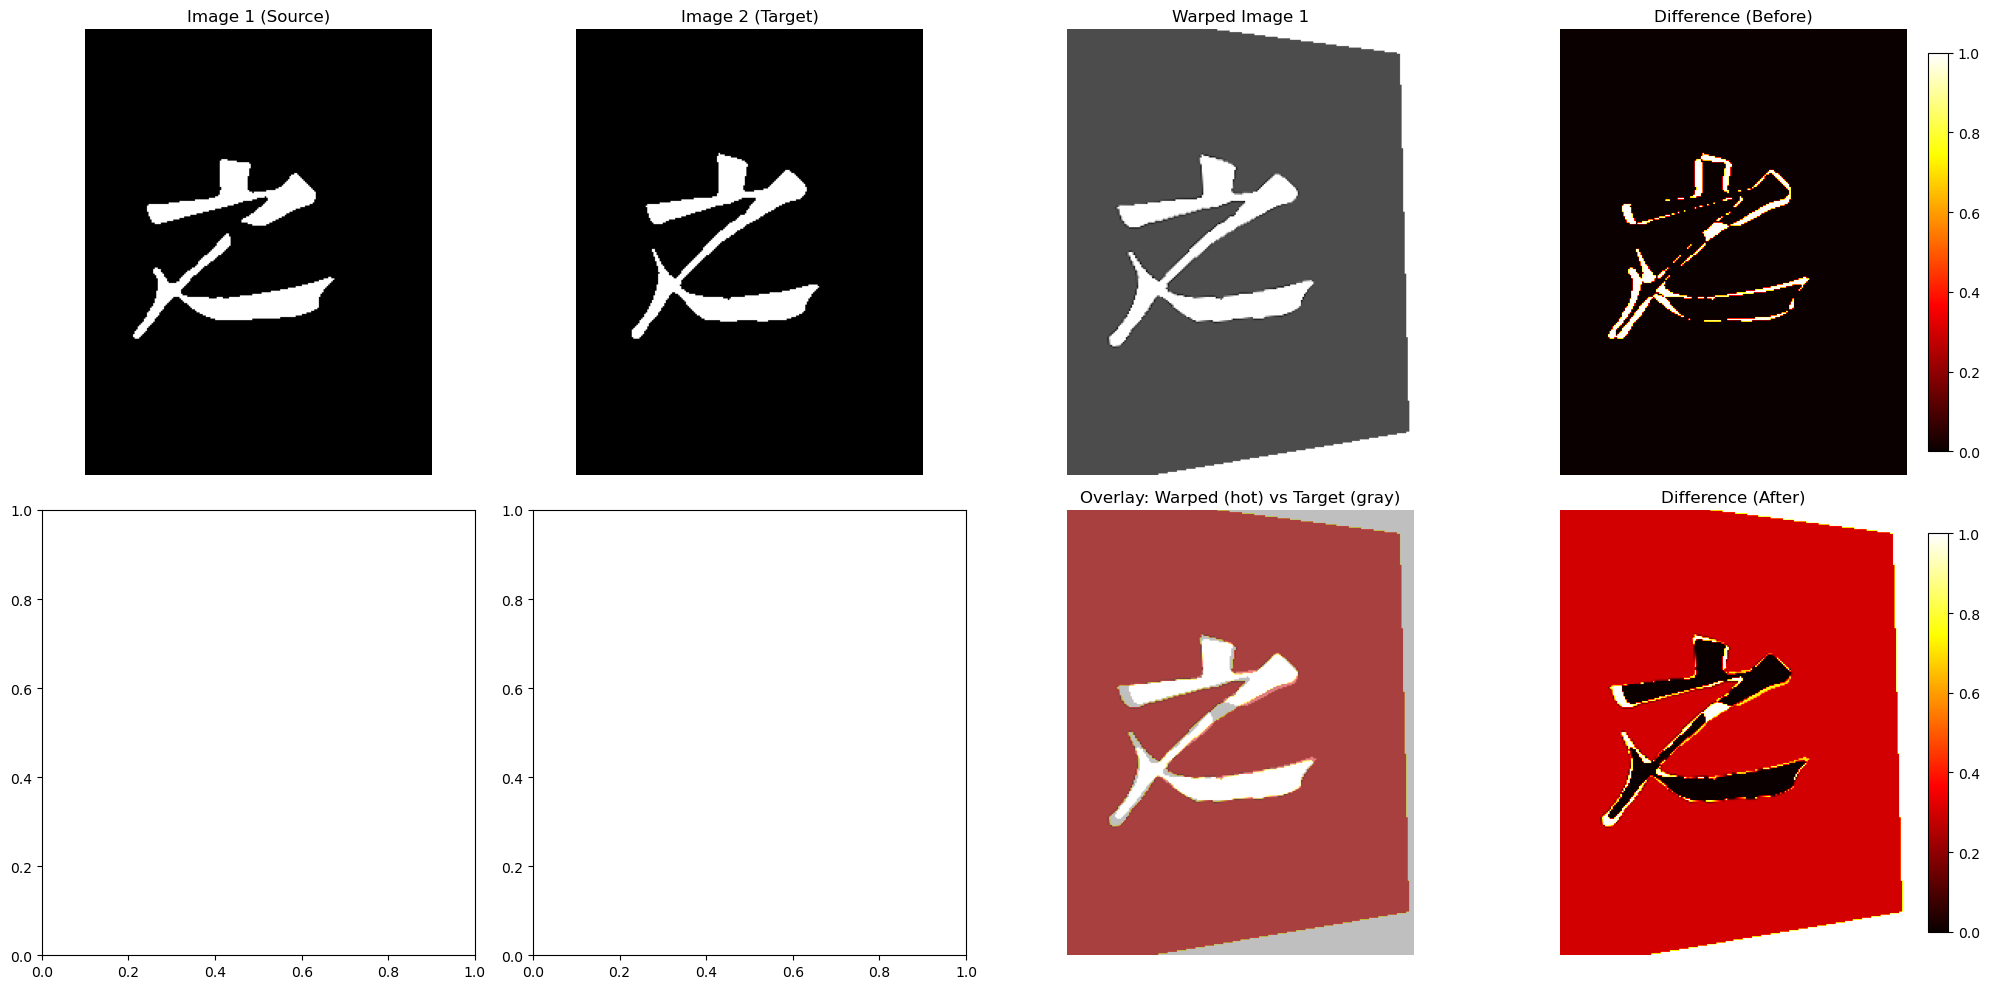


=== Registration Statistics ===
Mean absolute difference (before): 0.0243
Mean absolute difference (after): 0.3447
Improvement: -1321.0%


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import ot
from scipy.ndimage import map_coordinates

def plot_registration(im1, im2, warped):
    """
    Visualize the registration by showing displacement field and warped image.
    """
    h, w = im1.shape
    
    
    # Plotting
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    
    # Original images
    axes[0, 0].imshow(im1, cmap='gray')
    axes[0, 0].set_title('Image 1 (Source)')
    axes[0, 0].axis('off')
    
    axes[0, 1].imshow(im2, cmap='gray')
    axes[0, 1].set_title('Image 2 (Target)')
    axes[0, 1].axis('off')
    
    # Warped image
    axes[0, 2].imshow(warped, cmap='gray')
    axes[0, 2].set_title('Warped Image 1')
    axes[0, 2].axis('off')
    
    # Difference before warping
    diff_before = np.abs(im1 - im2)
    im_diff_before = axes[0, 3].imshow(diff_before, cmap='hot')
    axes[0, 3].set_title('Difference (Before)')
    axes[0, 3].axis('off')
    plt.colorbar(im_diff_before, ax=axes[0, 3], fraction=0.046)
    
    
    
    # Overlay: warped vs target
    axes[1, 2].imshow(im1, cmap='gray', alpha=0.5)
    axes[1, 2].imshow(warped, cmap='hot', alpha=0.5)
    axes[1, 2].set_title('Overlay: Warped (hot) vs Target (gray)')
    axes[1, 2].axis('off')
    
    # Difference after warping
    diff_after = np.abs(warped - im1)
    im_diff_after = axes[1, 3].imshow(diff_after, cmap='hot')
    axes[1, 3].set_title('Difference (After)')
    axes[1, 3].axis('off')
    plt.colorbar(im_diff_after, ax=axes[1, 3], fraction=0.046)
    
    plt.tight_layout()
    plt.show()
    
    # Print some statistics
    print(f"\n=== Registration Statistics ===")
    print(f"Mean absolute difference (before): {diff_before.mean():.4f}")
    print(f"Mean absolute difference (after): {diff_after.mean():.4f}")
    print(f"Improvement: {(1 - diff_after.mean()/diff_before.mean())*100:.1f}%")


plot_registration(im1.cpu(), im2.cpu(), warped.cpu().squeeze(0).squeeze(0))

## Second step: finer matching

The initial L2-based matching serves as a fast filtering step, but L2 distance between histograms is relatively coarse. We deliberately used a permissive threshold to ensure no true matches are missed at this stage.

We now refine these candidate matches using the Cyclic Earth Mover's Distance (CEMD), which is more robust for comparing histogram descriptors but computationally expensive. By applying CEMD only to the filtered candidates rather than all possible pairs, we achieve both accuracy and efficiency.

We use more bins for the computation of the HOG this time, as the CEMD can better exploit the finer angular resolution without being as sensitive to small misalignments as L2 distance.

In [ ]:
# featureMatching_params = featureMatchingParameters(
#     metric          = "CEMD",
#     epsilon         = eps,
#     reciprocal_only = True,
#     partial_output  = False,
#     distribution='gamma'
# )

# feature_matcher = featureMatching(featureMatching_params)


# matches, deltas, total_dissimilarities = feature_matcher.match(
#     query_histograms=histograms,
#     key_histograms=histograms
# )


(4066, 576)

### Patches with min/max entropy

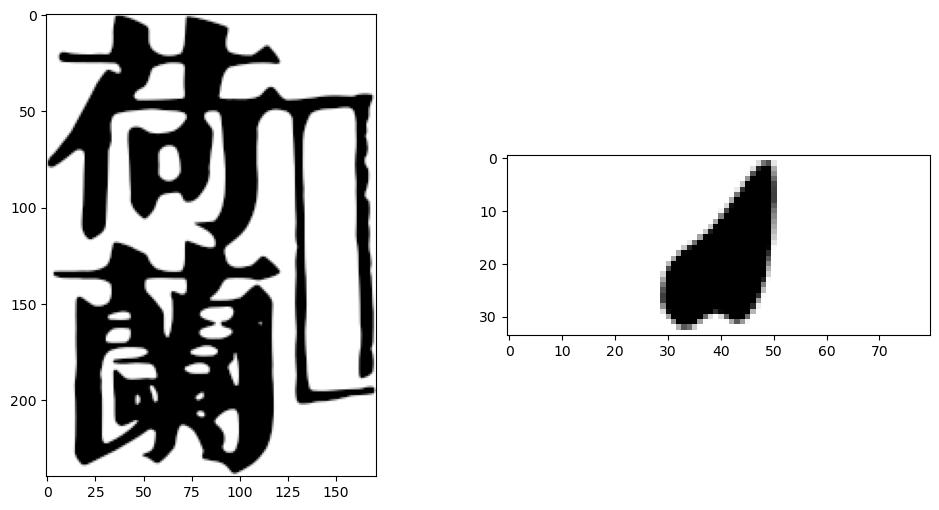

In [21]:
h = histograms / (histograms.sum(-1, keepdim=True)+1e-6)
h = h * torch.log(h+1e-7)
h = h.sum((-1, -2))
h.argmin()

i_hmin = h.argmin().cpu().item()
i_hmax = h.argmax().cpu().item()

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(patches_df['svg'][i_hmin].render(), cmap='gray')
plt.subplot(1,2,2)
plt.imshow(patches_df['svg'][i_hmax].render(), cmap='gray')


In [45]:
N

13887

In [38]:
import networkx as nx

match_indices = matches
delta = nlfa


gamma = 50


N = len(histograms)

print("Building graph...")
G = nx.Graph()
G.add_nodes_from(range(N))
edges = [(int(i.item()), int(j.item()), nlfa[i, j].item()) for i, j in match_indices if i != j]
G.add_weighted_edges_from(edges)

import igraph as ig
import leidenalg as la
G_ig = ig.Graph.from_networkx(G)
partition = la.find_partition(G_ig, la.RBConfigurationVertexPartition, resolution_parameter=gamma)

communities = []
for i in range(len(partition)):
    community = set([node for node, comm in enumerate(partition.membership) if comm == i])
    communities.append(community)



def get_random_happax(communities):
    i = np.random.randint(0, len(communities))
    if len(communities[i]) > 1:
        return get_random_happax(communities)
    return communities[i].pop()


def get_random_easy(communities):
    i = np.random.randint(0, len(communities))
    if len(communities[i]) < 60:
        return get_random_easy(communities)
    return communities[i].pop()


Building graph...



Community 39 Analysis
Community size: 87 patches
PCA computed with 10 components


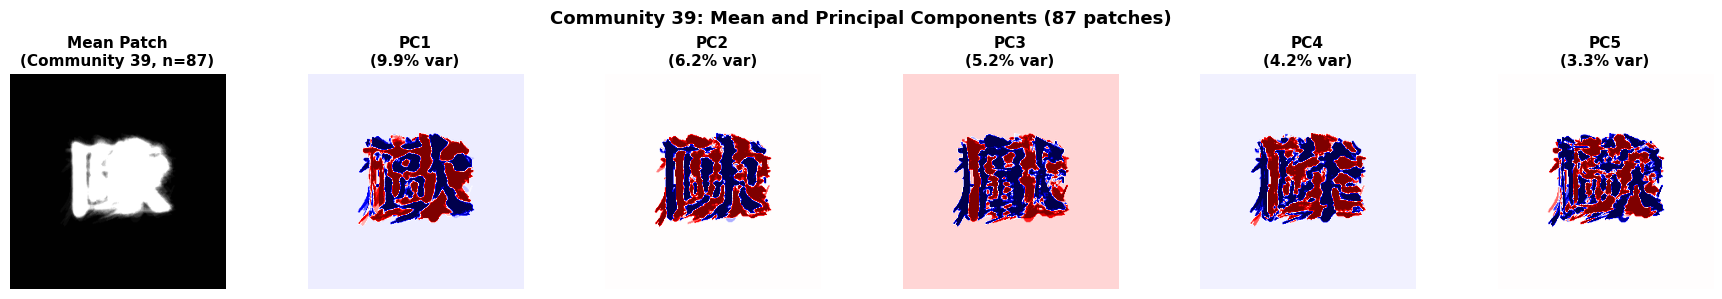

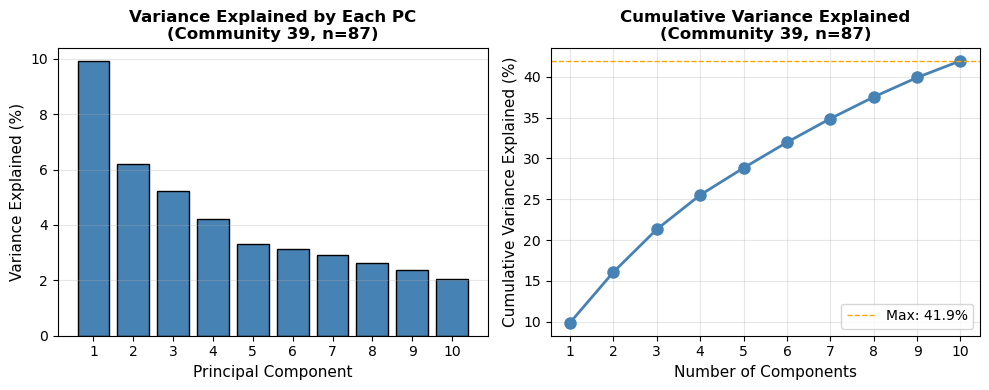

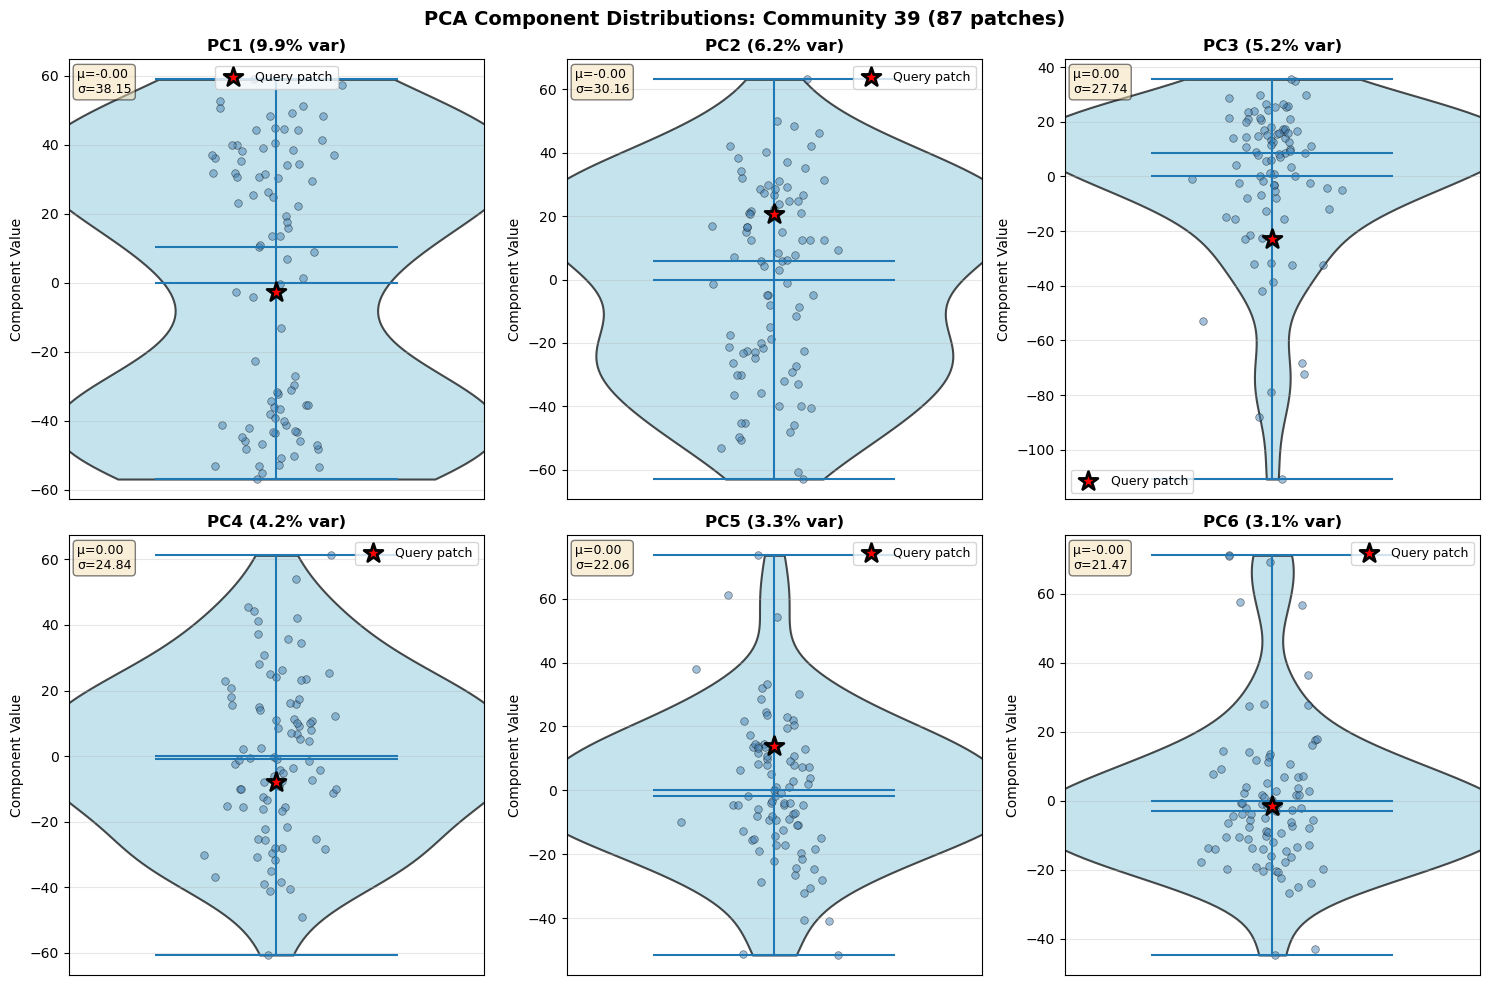

PCA Analysis:
  - Total variance explained by 10 components: 41.9%
  - Note: Only 41.9% variance achievable with 10 components


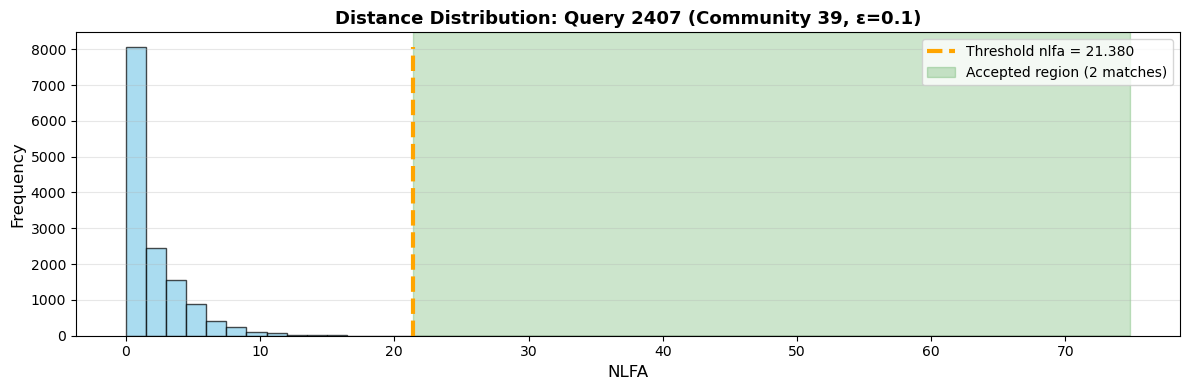

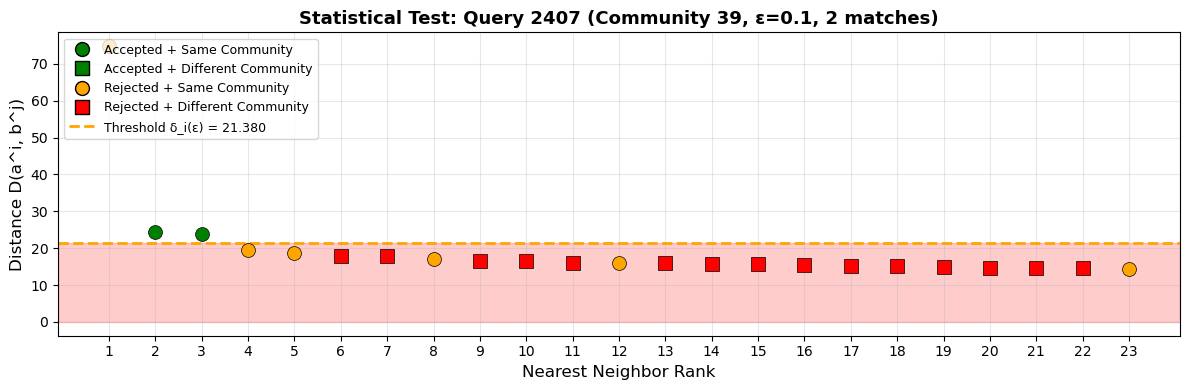

/tmp/ipykernel_29632/707570200.py:418: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/mathis/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


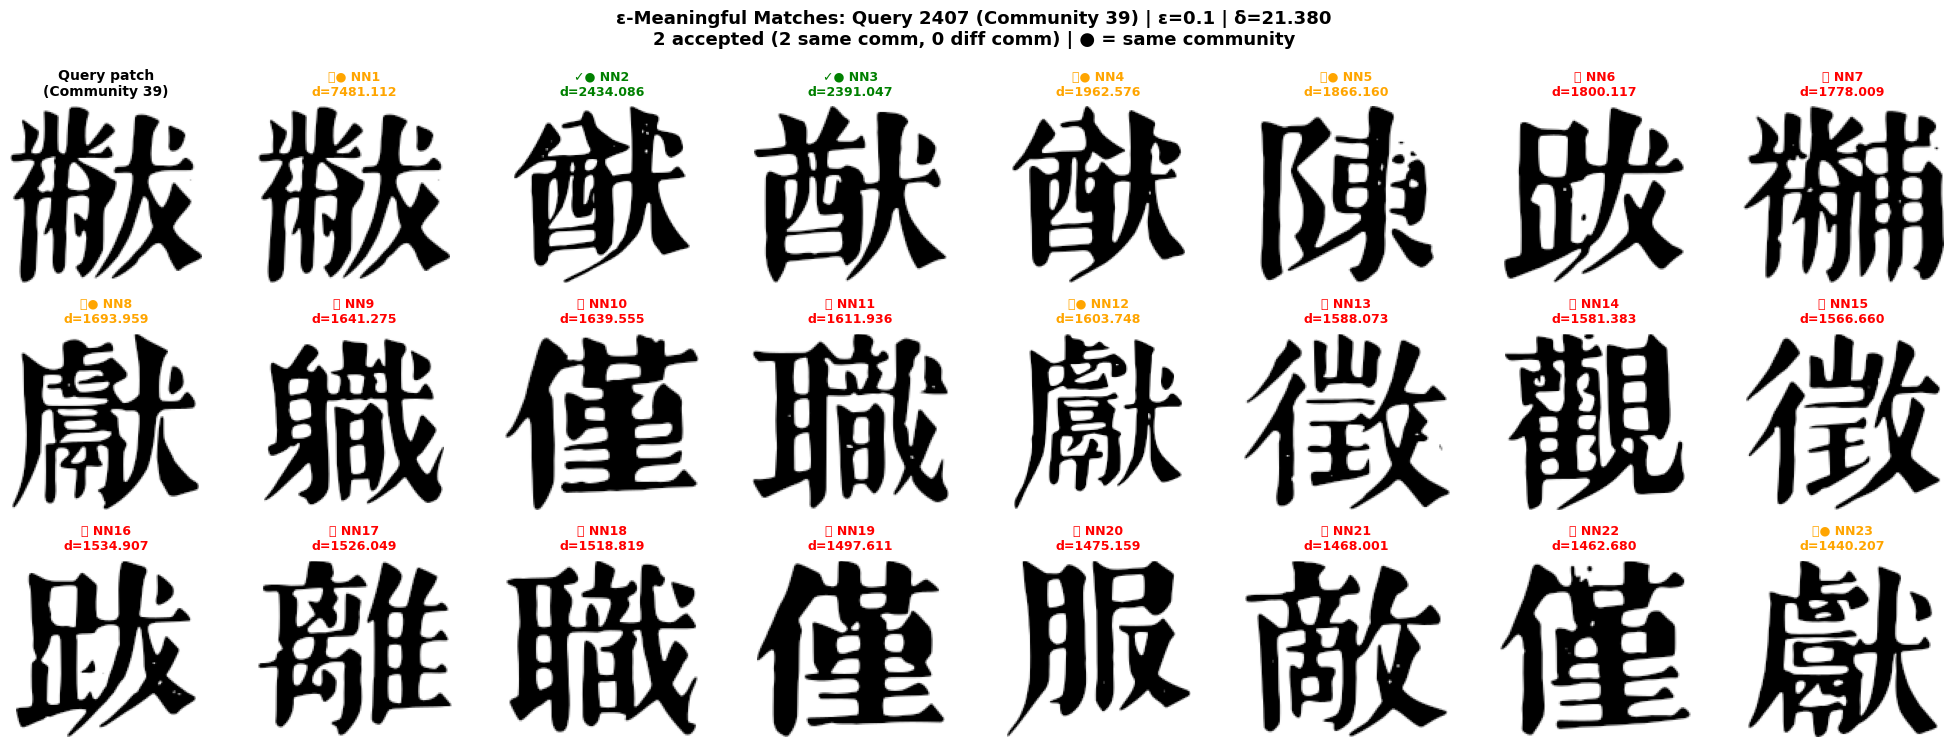


Query Patch 2407 - Community 39
Total community size: 87
Total accepted matches: 2
  - Same community: 2
  - Different community: 0
Among top 23 nearest neighbors:
  - Same community: 8
  - Different community: 15


In [23]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
# import seaborn as sns

log_quantile = nlfa

# Pick a random query
i = np.random.randint(0, len(patches_df['svg']))
n_to_show = min(23, len(patches_df['svg']))

# Find which community the query belongs to
query_community_idx = None
for comm_idx, community in enumerate(communities):
    if i in community:
        query_community_idx = comm_idx
        break

# Get all matches for query i from the statistical test
query_matches = match_indices[match_indices[:, 0] == i][:, 1]

# Compute distances from query i to all candidates
D_i = nlfa[i].detach().cpu().numpy()

# Get sorted candidate indices by distance (nearest first)
sorted_indices = np.argsort(-D_i)
sorted_distances = D_i[sorted_indices]

# Determine which are accepted (ε-meaningful matches)
accepted_mask = np.isin(sorted_indices[:n_to_show], query_matches.cpu().numpy())

# Determine which are in the same community
same_community_mask = np.array([idx in communities[query_community_idx] 
                                for idx in sorted_indices[:n_to_show]])

# ============================================================================
# NEW: PCA ANALYSIS OF COMMUNITY PATCHES (with small community handling)
# ============================================================================

# Get all patches from the query's community
community_indices = list(communities[query_community_idx])
community_size = len(community_indices)

print(f"\n{'='*60}")
print(f"Community {query_community_idx} Analysis")
print(f"{'='*60}")
print(f"Community size: {community_size} patches")

# Only perform PCA if community is large enough
MIN_PATCHES_FOR_PCA = 3

if community_size >= MIN_PATCHES_FOR_PCA:
    community_patches = [dataset[idx].unsqueeze(0) for idx in community_indices]
    # community_patches = hog.normalize(community_patches)
    
    # Flatten patches for PCA
    community_patches_flat = torch.stack([patch.flatten() for patch in community_patches]).cpu().numpy()
    
    # Compute mean patch
    mean_patch_flat = community_patches_flat.mean(axis=0)
    mean_patch = mean_patch_flat.reshape(community_patches[0].shape)
    
    # Only do PCA if we have at least 2 samples and fewer features than samples
    # n_components must be <= min(n_samples, n_features)
    max_components = min(community_size - 1, community_patches_flat.shape[1])
    
    if community_size >= 2 and max_components >= 1:
        # Standardize features
        scaler = StandardScaler()
        community_patches_scaled = scaler.fit_transform(community_patches_flat)
        
        # Apply PCA with appropriate number of components
        n_components = min(10, max_components)
        pca = PCA(n_components=n_components)
        community_pca = pca.fit_transform(community_patches_scaled)
        
        # Reconstruct first few principal component patches
        n_pc_to_show = min(5, n_components)
        pc_patches = []
        for pc_idx in range(n_pc_to_show):
            # Get the principal component
            pc = pca.components_[pc_idx]
            # Transform back to original space
            pc_original = scaler.inverse_transform(pc.reshape(1, -1))
            pc_patch = pc.reshape(community_patches[0].shape)
            pc_patches.append(pc_patch)
        
        print(f"PCA computed with {n_components} components")
        
        # ============================================================================
        # VISUALIZATION 1: Mean and Principal Component Patches
        # ============================================================================
        
        fig, axs = plt.subplots(1, n_pc_to_show + 1, figsize=(3 * (n_pc_to_show + 1), 3))
        if n_pc_to_show == 0:  # Handle case with only mean patch
            axs = [axs]
        
        # Mean patch
        axs[0].imshow(torch_to_pil(torch.from_numpy(mean_patch)).resize((256, 256)), cmap="gray")
        axs[0].set_title(f'Mean Patch\n(Community {query_community_idx}, n={community_size})', 
                        fontweight='bold', fontsize=11)
        axs[0].axis('off')
        for spine in axs[0].spines.values():
            spine.set_edgecolor('blue')
            spine.set_linewidth(3)
            spine.set_visible(True)
        
        # Principal component patches
        for pc_idx in range(n_pc_to_show):
            ax = axs[pc_idx + 1]
            pc_patch_normalized = (pc_patches[pc_idx] - pc_patches[pc_idx].min()) / \
                                 (pc_patches[pc_idx].max() - pc_patches[pc_idx].min() + 1e-8)
            ax.imshow(torch_to_pil(torch.from_numpy(pc_patch_normalized)).resize((256, 256)), cmap="seismic")
            variance_explained = pca.explained_variance_ratio_[pc_idx] * 100
            ax.set_title(f'PC{pc_idx + 1}\n({variance_explained:.1f}% var)', fontweight='bold', fontsize=11)
            ax.axis('off')
            for spine in ax.spines.values():
                spine.set_edgecolor('orange')
                spine.set_linewidth(2)
                spine.set_visible(True)
        
        plt.suptitle(f'Community {query_community_idx}: Mean and Principal Components ({community_size} patches)', 
                     fontsize=13, fontweight='bold')
        plt.tight_layout()
        plt.show()
        
        # ============================================================================
        # VISUALIZATION 2: PCA Variance Explained
        # ============================================================================
        
        fig = plt.figure(figsize=(10, 4))
        
        plt.subplot(1, 2, 1)
        plt.bar(range(1, n_components + 1), pca.explained_variance_ratio_ * 100, 
               color='steelblue', edgecolor='black')
        plt.xlabel('Principal Component', fontsize=11)
        plt.ylabel('Variance Explained (%)', fontsize=11)
        plt.title(f'Variance Explained by Each PC\n(Community {query_community_idx}, n={community_size})', 
                 fontweight='bold')
        plt.xticks(range(1, n_components + 1))
        plt.grid(alpha=0.3, axis='y')
        
        plt.subplot(1, 2, 2)
        cumsum_var = np.cumsum(pca.explained_variance_ratio_ * 100)
        plt.plot(range(1, n_components + 1), cumsum_var, marker='o', linewidth=2, 
                markersize=8, color='steelblue')
        plt.xlabel('Number of Components', fontsize=11)
        plt.ylabel('Cumulative Variance Explained (%)', fontsize=11)
        plt.title(f'Cumulative Variance Explained\n(Community {query_community_idx}, n={community_size})', 
                 fontweight='bold')
        plt.xticks(range(1, n_components + 1))
        plt.grid(alpha=0.3)
        if cumsum_var[-1] < 95:
            plt.axhline(y=cumsum_var[-1], color='orange', linestyle='--', linewidth=1, 
                       label=f'Max: {cumsum_var[-1]:.1f}%')
        else:
            plt.axhline(y=95, color='red', linestyle='--', linewidth=1, label='95% threshold')
        plt.legend()
        
        plt.tight_layout()
        plt.show()
        
        # ============================================================================
        # VISUALIZATION 3: Violin Plots of PCA Components
        # ============================================================================
        
        n_pc_violin = min(6, n_components)
        n_cols = 3
        n_rows = int(np.ceil(n_pc_violin / n_cols))
        
        fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
        axs = np.atleast_1d(axs).ravel()
        
        query_idx_in_community = community_indices.index(i)
        
        for pc_idx in range(n_pc_violin):
            ax = axs[pc_idx]
            
            # Extract the values for THIS specific component
            component_values = community_pca[:, pc_idx]
            
            # For very small communities, violin plot might not work well
            # Use scatter + box plot instead
            if community_size <= 5:
                # Box plot
                bp = ax.boxplot([component_values], positions=[0], widths=0.4,
                               patch_artist=True, showmeans=True)
                bp['boxes'][0].set_facecolor('lightblue')
                bp['boxes'][0].set_alpha(0.7)
            else:
                # Violin plot for larger communities
                parts = ax.violinplot([component_values], positions=[0], widths=0.7,
                                     showmeans=True, showextrema=True, showmedians=True)
                for pc in parts['bodies']:
                    pc.set_facecolor('lightblue')
                    pc.set_alpha(0.7)
                    pc.set_edgecolor('black')
                    pc.set_linewidth(1.5)
            
            # Add individual points with jitter
            jitter_amount = 0.04 if community_size > 10 else 0.02
            jitter = np.random.normal(0, jitter_amount, size=len(component_values))
            ax.scatter(jitter, component_values, alpha=0.5, s=30, 
                      color='steelblue', edgecolors='black', linewidth=0.5)
            
            # Highlight query patch for THIS component
            query_value = component_values[query_idx_in_community]
            ax.scatter(0, query_value, 
                      s=200, color='red', marker='*', edgecolors='black', linewidth=2, 
                      label='Query patch', zorder=10)
            
            variance_explained = pca.explained_variance_ratio_[pc_idx] * 100
            ax.set_title(f'PC{pc_idx + 1} ({variance_explained:.1f}% var)', 
                        fontweight='bold', fontsize=12)
            ax.set_ylabel('Component Value', fontsize=10)
            ax.set_xticks([])
            ax.set_xlim([-0.3, 0.3])
            ax.grid(alpha=0.3, axis='y')
            ax.legend(fontsize=9)
            
            # Add statistics for THIS component
            mean_val = component_values.mean()
            std_val = component_values.std()
            ax.text(0.02, 0.98, f'μ={mean_val:.2f}\nσ={std_val:.2f}', 
                   transform=ax.transAxes, fontsize=9, verticalalignment='top',
                   bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
        
        # Hide unused subplots
        for pc_idx in range(n_pc_violin, len(axs)):
            axs[pc_idx].axis('off')
        
        plt.suptitle(f'PCA Component Distributions: Community {query_community_idx} ({community_size} patches)', 
                     fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()
        
        print(f"PCA Analysis:")
        print(f"  - Total variance explained by {n_components} components: {cumsum_var[-1]:.1f}%")
        if cumsum_var[-1] >= 95:
            print(f"  - Components needed for 95% variance: {np.argmax(cumsum_var >= 95) + 1}")
        else:
            print(f"  - Note: Only {cumsum_var[-1]:.1f}% variance achievable with {n_components} components")
    
    else:
        # Community too small for PCA, just show mean
        print(f"⚠️  Community too small for PCA (size={community_size})")
        print(f"   Showing mean patch only...")
        
        fig, ax = plt.subplots(1, 1, figsize=(4, 4))
        ax.imshow(torch_to_pil(torch.from_numpy(mean_patch)).resize((256, 256)), cmap="gray")
        ax.set_title(f'Mean Patch\n(Community {query_community_idx}, n={community_size})', 
                    fontweight='bold', fontsize=12)
        ax.axis('off')
        for spine in ax.spines.values():
            spine.set_edgecolor('blue')
            spine.set_linewidth(3)
            spine.set_visible(True)
        plt.tight_layout()
        plt.show()

else:
    print(f"⚠️  Community too small for analysis (size={community_size}, min={MIN_PATCHES_FOR_PCA})")
    print(f"   Showing all patches in community...")
    
    # Show all patches in the small community
    fig, axs = plt.subplots(1, community_size, figsize=(3 * community_size, 3))
    if community_size == 1:
        axs = [axs]
    
    for idx, patch_idx in enumerate(community_indices):
        axs[idx].imshow(torch_to_pil(patches_df.iloc[patch_idx]['bin_patch'][None, ...]).resize((256, 256)), cmap="gray")
        is_query = (patch_idx == i)
        title = f'{"Query" if is_query else f"Patch {idx+1}"}\n(idx={patch_idx})'
        color = 'red' if is_query else 'blue'
        axs[idx].set_title(title, fontweight='bold', fontsize=10, color=color)
        axs[idx].axis('off')
        for spine in axs[idx].spines.values():
            spine.set_edgecolor(color)
            spine.set_linewidth(3 if is_query else 2)
            spine.set_visible(True)
    
    plt.suptitle(f'All Patches in Community {query_community_idx} ({community_size} patches)', 
                 fontsize=13, fontweight='bold')
    plt.tight_layout()
    plt.show()

# ============================================================================
# ORIGINAL VISUALIZATIONS (unchanged)
# ============================================================================

# 1. HISTOGRAM: Distribution of all distances for query i
plt.figure(figsize=(12, 4))
hist_values, bin_edges, patches_hist = plt.hist(nlfa[i], bins=50, color='skyblue', 
                                                  edgecolor='black', alpha=0.7)
thresh_value = nlfa_threshold

plt.vlines(thresh_value, 0, hist_values.max(), color='orange', linestyle='--', 
           linewidth=3, label=f'Threshold nlfa = {thresh_value:.3f}')

plt.axvspan(nlfa[i].max(), thresh_value, alpha=0.2, color='green', 
            label=f'Accepted region ({len(query_matches)} matches)')

plt.xlabel('NLFA', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title(f'Distance Distribution: Query {i} (Community {query_community_idx}, ε={eps})', 
          fontsize=13, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

# 2. SCATTER PLOT: Nearest neighbors with acceptance status AND community membership
plt.figure(figsize=(12, 4))

colors = []
markers = []
for accepted, same_comm in zip(accepted_mask, same_community_mask):
    if same_comm:
        colors.append('green' if accepted else 'orange')
        markers.append('o')
    else:
        colors.append('green' if accepted else 'red')
        markers.append('s')

for rank, (dist, color, marker) in enumerate(zip(sorted_distances[:n_to_show], colors, markers), 1):
    plt.scatter(rank, dist, c=color, s=100, marker=marker, zorder=3, edgecolors='black', linewidth=0.5)

plt.axhline(y=thresh_value, color='orange', linestyle='--', linewidth=2, 
            label=f'Threshold NLFA = {thresh_value:.3f}')

plt.axhspan(thresh_value, 0, alpha=0.2, 
            color='red', label='Rejected region')

from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=10, 
           label='Accepted + Same Community', markeredgecolor='black'),
    Line2D([0], [0], marker='s', color='w', markerfacecolor='green', markersize=10, 
           label='Accepted + Different Community', markeredgecolor='black'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='orange', markersize=10, 
           label='Rejected + Same Community', markeredgecolor='black'),
    Line2D([0], [0], marker='s', color='w', markerfacecolor='red', markersize=10, 
           label='Rejected + Different Community', markeredgecolor='black'),
    Line2D([0], [0], color='orange', linestyle='--', linewidth=2, 
           label=f'Threshold δ_i(ε) = {thresh_value:.3f}')
]

plt.xlabel('Nearest Neighbor Rank', fontsize=12)
plt.ylabel('Distance D(a^i, b^j)', fontsize=12)
plt.title(f'Statistical Test: Query {i} (Community {query_community_idx}, ε={eps}, {len(query_matches)} matches)', 
          fontsize=13, fontweight='bold')
plt.xticks(range(1, n_to_show + 1))
plt.grid(alpha=0.3)
plt.legend(handles=legend_elements, fontsize=9, loc='upper left')
plt.tight_layout()
plt.show()

# 3. PATCH VISUALIZATION: Query and nearest neighbors
n_total = n_to_show + 1
n_cols = min(8, n_total)
n_rows = int(np.ceil(n_total / n_cols))

fig_width = min(23, n_cols * 2.5)
fig_height = n_rows * 2.5

fig, axs = plt.subplots(n_rows, n_cols, figsize=(fig_width, fig_height))
axs = np.atleast_2d(axs).ravel()

ax = axs[0]
ax.imshow(patches_df['svg'][i].render(), cmap="gray")
ax.set_title(f'Query patch\n(Community {query_community_idx})', fontweight='bold', fontsize=10, pad=8)
ax.axis('off')

for spine in ax.spines.values():
    spine.set_edgecolor('blue')
    spine.set_linewidth(4)
    spine.set_visible(True)

for j in range(n_to_show):
    candidate_idx = sorted_indices[j]
    distance = sorted_distances[j]
    
    ax = axs[j + 1]
    ax.imshow(patches_df['svg'][candidate_idx].render(), cmap="gray")
    
    is_accepted = accepted_mask[j]
    is_same_community = same_community_mask[j]
    
    if is_same_community:
        status = '✓●' if is_accepted else '❌●'
        color = 'green' if is_accepted else 'orange'
        border_style = '-'
    else:
        status = '✓' if is_accepted else '❌'
        color = 'green' if is_accepted else 'red'
        border_style = '--'
    
    ax.set_title(f'{status} NN{j+1}\nd={distance*100:.3f}', 
                 fontweight='bold', color=color, fontsize=9, pad=8)
    ax.axis('off')
    
    for spine in ax.spines.values():
        spine.set_edgecolor(color)
        spine.set_linewidth(3)
        spine.set_linestyle(border_style)
        spine.set_visible(True)

for j in range(n_total, len(axs)):
    axs[j].axis('off')
    axs[j].set_visible(False)

same_comm_accepted = sum(accepted_mask & same_community_mask)
diff_comm_accepted = sum(accepted_mask & ~same_community_mask)

plt.suptitle(f'ε-Meaningful Matches: Query {i} (Community {query_community_idx}) | ε={eps} | δ={thresh_value:.3f}\n'
             f'{len(query_matches)} accepted ({same_comm_accepted} same comm, {diff_comm_accepted} diff comm) | '
             f'● = same community', 
             fontsize=13, fontweight='bold', y=0.99)
plt.tight_layout()
plt.show()

# Print summary statistics
print(f"\n{'='*60}")
print(f"Query Patch {i} - Community {query_community_idx}")
print(f"{'='*60}")
print(f"Total community size: {len(communities[query_community_idx])}")
print(f"Total accepted matches: {len(query_matches)}")
print(f"  - Same community: {same_comm_accepted}")
print(f"  - Different community: {diff_comm_accepted}")
print(f"Among top {n_to_show} nearest neighbors:")
print(f"  - Same community: {sum(same_community_mask)}")
print(f"  - Different community: {sum(~same_community_mask)}")

In [39]:
stats = {
    'Modularity' : nx.community.modularity(G, communities),
    'Density': nx.density(G)
}
stats

{'Modularity': 0.3793966153321614, 'Density': 0.004430889220550876}

In [25]:
community_sizes = [len(c) for c in communities]
print(sorted(community_sizes, reverse=True))


thresh = 1
n_happax = 0
for community_size in community_sizes:
    if community_size <= thresh:
        n_happax += community_size

print(f'{100 * n_happax / sum(community_sizes):.3f} % d\'happax')

[298, 215, 204, 199, 183, 170, 168, 166, 165, 161, 154, 153, 148, 145, 140, 139, 133, 131, 126, 124, 123, 123, 119, 116, 112, 112, 107, 100, 100, 97, 97, 97, 96, 95, 95, 93, 91, 90, 90, 87, 87, 81, 79, 78, 77, 76, 76, 75, 73, 73, 72, 70, 69, 68, 67, 67, 67, 66, 64, 64, 61, 59, 58, 58, 58, 58, 57, 57, 54, 54, 53, 52, 52, 52, 51, 50, 48, 47, 47, 45, 45, 43, 42, 42, 40, 40, 39, 39, 38, 37, 37, 36, 36, 36, 36, 35, 35, 35, 35, 34, 34, 34, 33, 33, 32, 31, 31, 31, 31, 30, 30, 30, 30, 30, 30, 30, 29, 29, 29, 28, 28, 27, 27, 27, 26, 25, 24, 24, 24, 23, 23, 23, 23, 23, 23, 22, 22, 22, 21, 21, 21, 20, 20, 20, 19, 19, 19, 19, 19, 19, 19, 19, 19, 18, 18, 18, 18, 18, 17, 17, 17, 17, 16, 16, 16, 16, 15, 15, 15, 15, 15, 14, 14, 14, 14, 14, 14, 13, 13, 13, 13, 13, 12, 12, 12, 12, 12, 12, 12, 12, 12, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 10, 10, 10, 10, 10, 10, 10, 10, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,

In [52]:
nx.degree_histogram(G)
nx.average_degree_connectivity(G)

{10: 17.083132530120483,
 7: 16.40246796392976,
 5: 12.972106824925817,
 65: 68.67873303167421,
 224: 257.2767857142857,
 3: 10.310502283105023,
 0: 0,
 272: 265.125,
 19: 25.218693284936478,
 18: 24.43817663817664,
 16: 23.92799707602339,
 273: 276.95494505494503,
 74: 95.37887887887888,
 64: 103.01060267857143,
 94: 106.20867430441899,
 389: 385.6404562982005,
 35: 46.82607489597781,
 14: 22.78508495909377,
 75: 82.15118644067796,
 139: 163.2685851318945,
 1: 5.574626865671642,
 9: 18.91387024608501,
 253: 242.00658761528328,
 8: 15.524439102564102,
 6: 12.560690943043884,
 13: 22.996910719802287,
 218: 187.8302752293578,
 96: 99.57819444444445,
 240: 252.64166666666668,
 126: 126.1159420289855,
 113: 120.13846954711087,
 24: 31.389655172413793,
 17: 29.309644670050762,
 4: 9.727331606217616,
 23: 37.484925420501426,
 110: 118.93428571428572,
 53: 68.9622641509434,
 128: 130.9969429347826,
 127: 133.42336895388075,
 78: 86.17339743589744,
 131: 136.65587786259542,
 29: 37.70674122398

In [26]:
def get_community(communities, min_size=None, max_size=None):
    i = np.random.randint(0, len(communities))
    if min_size is not None and len(communities[i])<min_size:
        return get_community(communities, min_size, max_size)
    if max_size is not None and len(communities[i])>max_size:
        return get_community(communities, min_size, max_size)
    return i


Showing community 103: 35 nodes
Computing t-SNE layout...


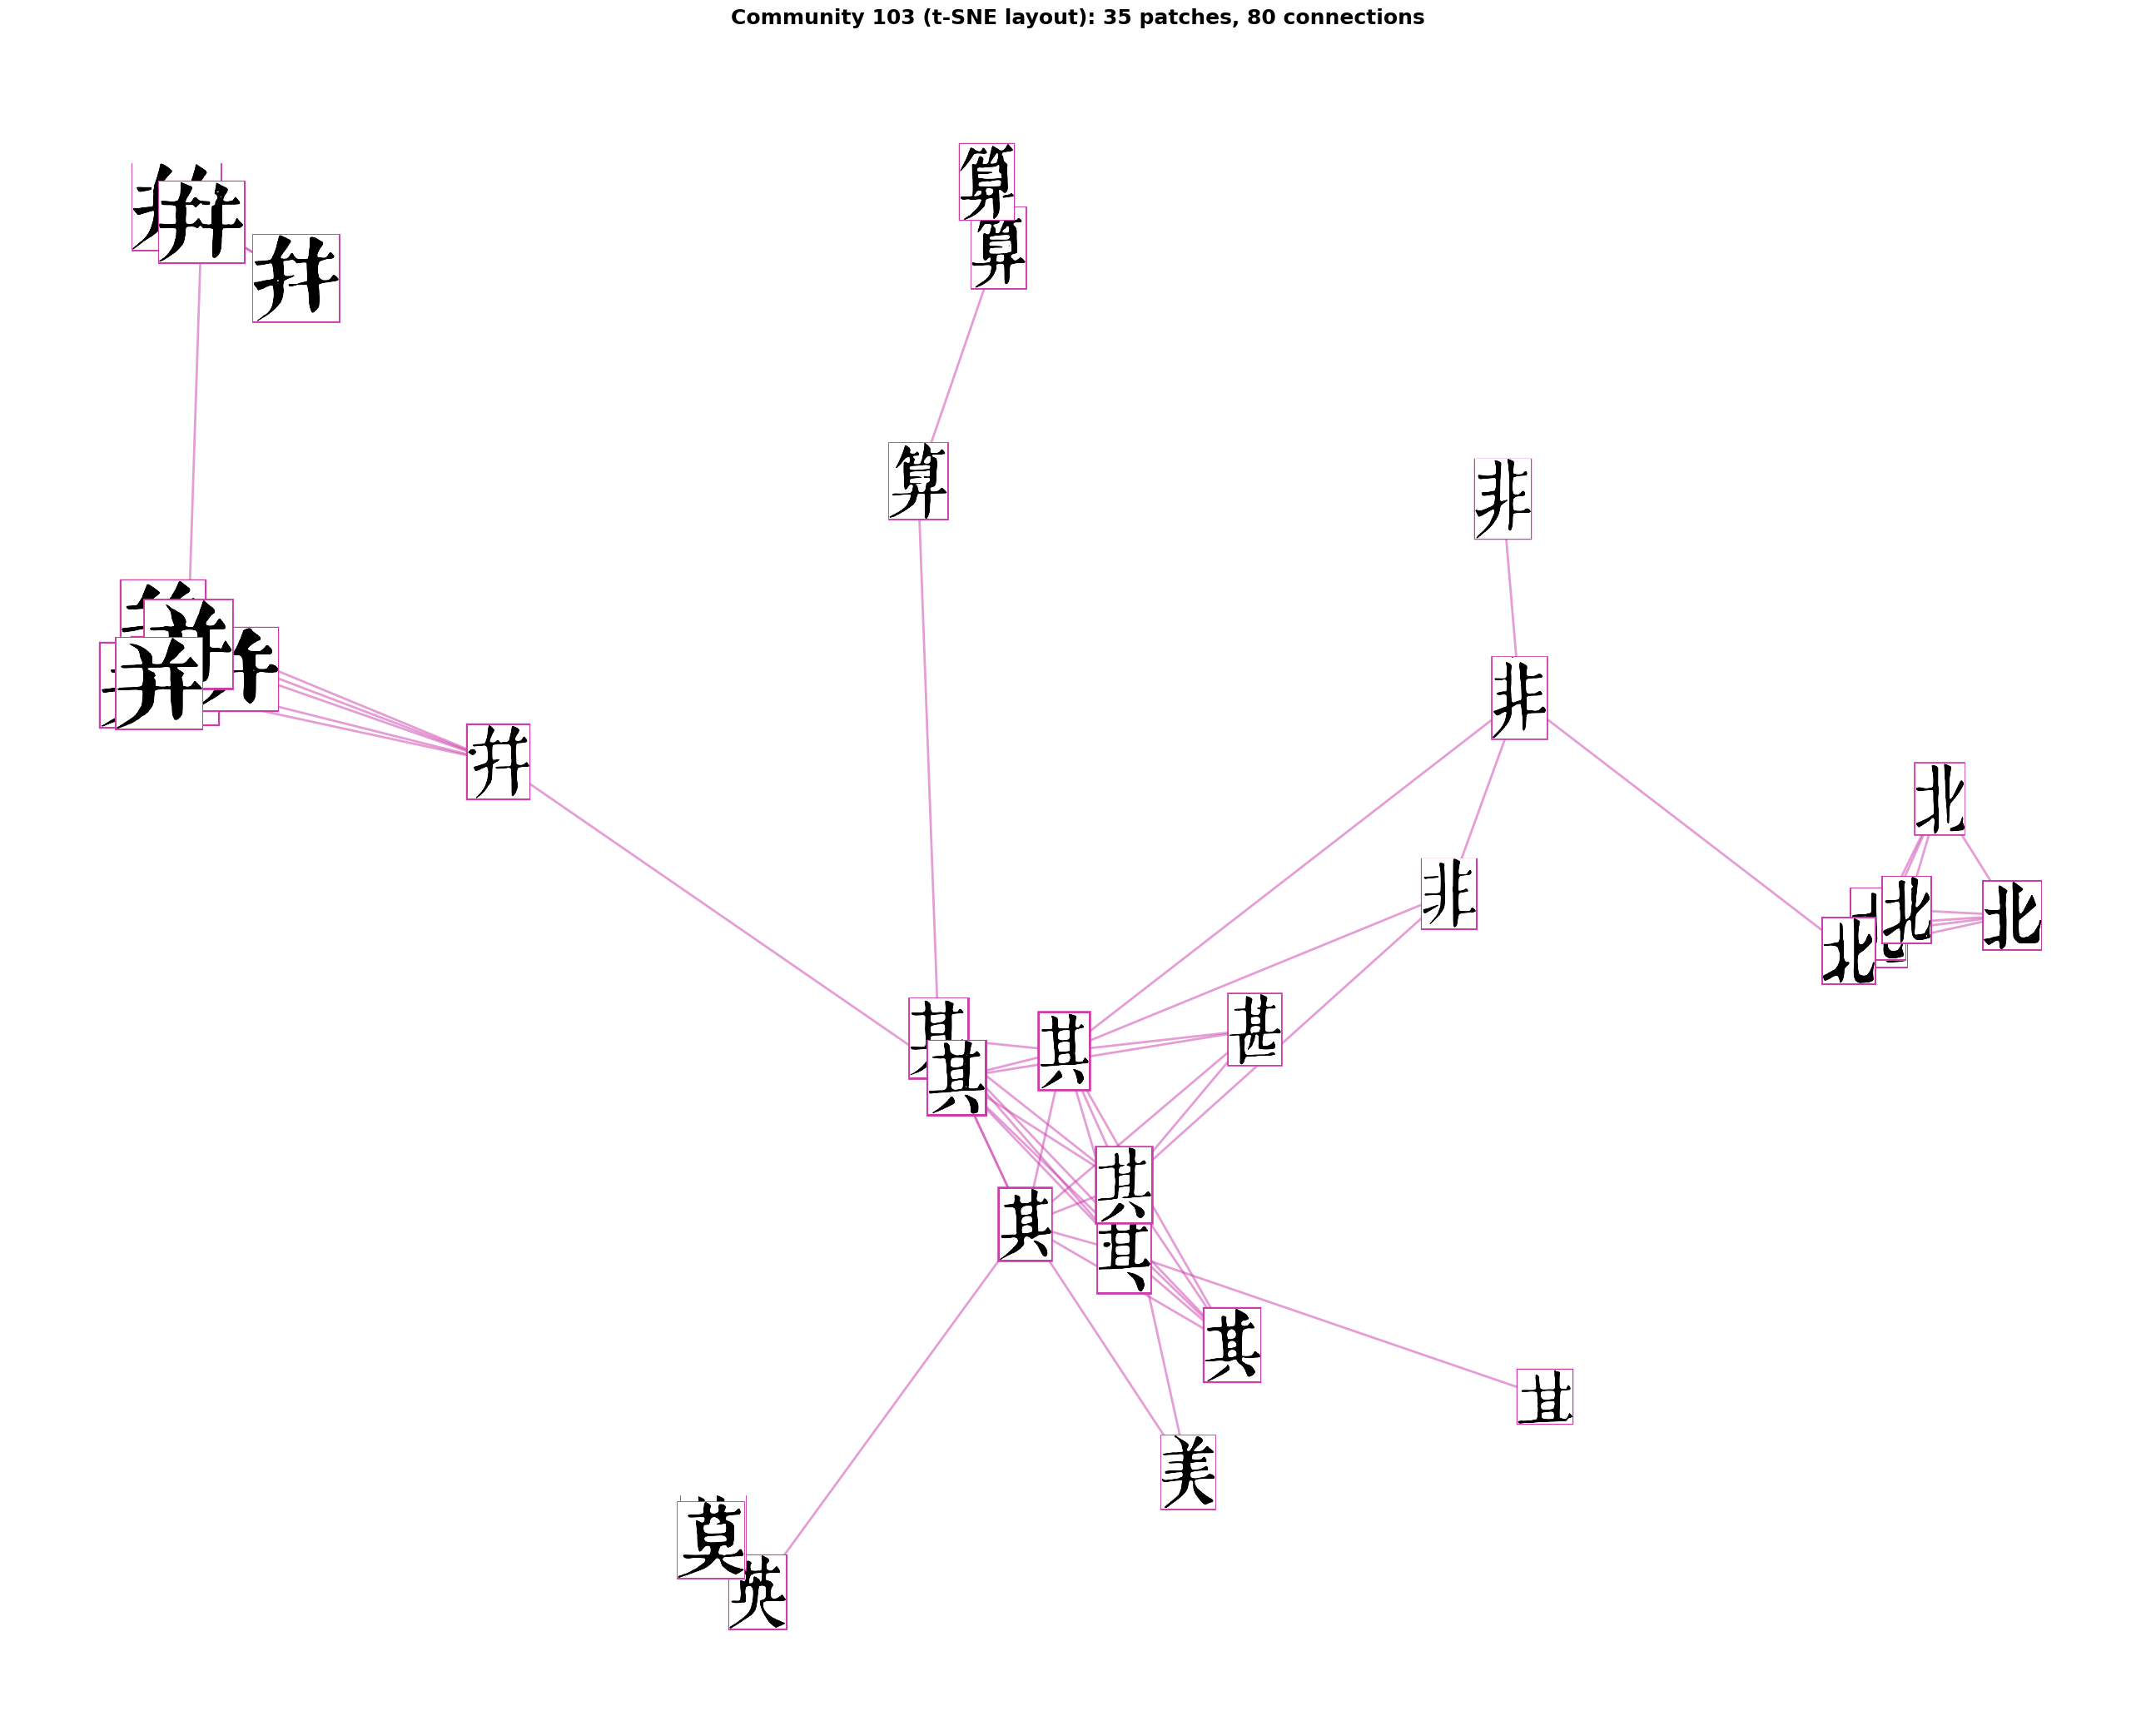

✓ Visualization complete


In [54]:
import random
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from sklearn.manifold import TSNE

# Sort communities by size
community_sizes = [(i, len(comm)) for i, comm in enumerate(communities)]
community_sizes.sort(key=lambda x: x[1], reverse=True)

# Select which community to show (0 = largest, 1 = second largest, etc.)
COMMUNITY_TO_SHOW = 0  # Change this number to show different communities

selected_comm_idx = community_sizes[COMMUNITY_TO_SHOW][0]

# selected_comm_idx = 23
selected_comm_idx = get_community(communities, min_size=20)

selected_nodes = list(communities[selected_comm_idx])

print(f"\nShowing community {selected_comm_idx}: {len(selected_nodes)} nodes")

# Create subgraph
G_sub = G.subgraph(selected_nodes).copy()

# ============================================
# t-SNE LAYOUT (instead of spring layout)
# ============================================

print("Computing t-SNE layout...")

# Get the feature vectors for selected nodes
X_selected = histograms.reshape(histograms.shape[0], -1)[selected_nodes].cpu().numpy()

# Compute t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(selected_nodes)-1))
tsne_coords = tsne.fit_transform(X_selected)

# Scale to similar range as before (optional, for similar visualization size)
tsne_coords = tsne_coords * 20 / tsne_coords.std()

# Create position dictionary
pos = {node: tsne_coords[i] for i, node in enumerate(selected_nodes)}
coords = tsne_coords

# ============================================
# Visualization
# ============================================

# Adjust display size
N_sub = len(selected_nodes)
if N_sub < 50:
    display_size, zoom = 64, 1.2
elif N_sub < 200:
    display_size, zoom = 48, 0.9
elif N_sub < 500:
    display_size, zoom = 32, 0.7
else:
    display_size, zoom = 24, 0.5

zoom /= 4

# Create figure
fig, ax = plt.subplots(figsize=(26, 22), dpi=100)

# Generate community color
random.seed(42 + selected_comm_idx)
hue = random.random()
import colorsys
r, g, b = colorsys.hsv_to_rgb(hue, 0.7, 0.8)
community_color = [r, g, b, 1.0]

# Draw edges
for i, j in G_sub.edges():
    i_idx = selected_nodes.index(i)
    j_idx = selected_nodes.index(j)
    ax.plot([coords[i_idx, 0], coords[j_idx, 0]], 
           [coords[i_idx, 1], coords[j_idx, 1]], 
           color=community_color, alpha=0.5, linewidth=2.0, zorder=1)

# Draw nodes with patches
degrees_sub = np.array([G_sub.degree(node) for node in selected_nodes])

for idx, node in enumerate(selected_nodes):
    patch = patches_df['svg'][node].render(scale=2)
    pil_img = Image.fromarray(patch)
    
    imagebox = OffsetImage(pil_img, zoom=zoom, cmap='gray')
    
    # Border width by degree
    if degrees_sub.max() > 0:
        border_width = 1.5 + 2.5 * (degrees_sub[idx] / degrees_sub.max())
    else:
        border_width = 1.5
    
    ab = AnnotationBbox(
        imagebox, 
        (coords[idx, 0], coords[idx, 1]),
        frameon=True,
        pad=0.0,
        bboxprops=dict(
            edgecolor=community_color,
            linewidth=border_width,
            facecolor='white',
            alpha=1.0
        ),
        zorder=10
    )
    ax.add_artist(ab)

# Finalize plot
margin = 3
ax.set_xlim(coords[:, 0].min() - margin, coords[:, 0].max() + margin)
ax.set_ylim(coords[:, 1].min() - margin, coords[:, 1].max() + margin)
ax.set_aspect('equal')
ax.axis('off')

ax.set_title(f'Community {selected_comm_idx} (t-SNE layout): {N_sub} patches, {G_sub.number_of_edges()} connections', 
            fontsize=18, fontweight='bold', pad=20)

plt.tight_layout()
plt.show()

print(f"✓ Visualization complete")

In [58]:
comms_to_save = [
    125, 142, 170, 12, 59, 24
]

path = Path('data/extracted/communities_clean/')

for i in comms_to_save:
    idx = communities[i]
    folder = path/f'{i}'
    folder.mkdir(exist_ok=True, parents=True)

    for j in idx:
        svg = patches_df['svg'][j]
        svg.save(folder / f'{j}.svg')


GMM Generation from Community 12
Community size: 53 patches
PCA: 20 components explain 81.6% variance
GMM: fitted with 3 Gaussian components
GMM converged: True, iterations: 2
Generated 12 new samples in PCA space


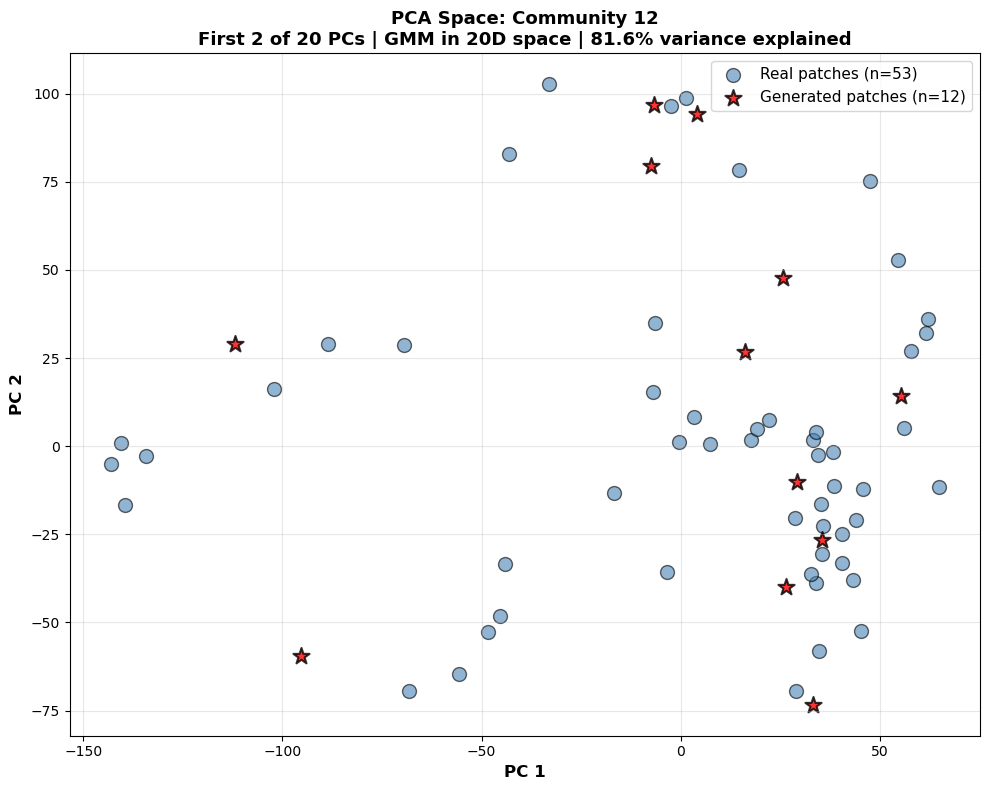

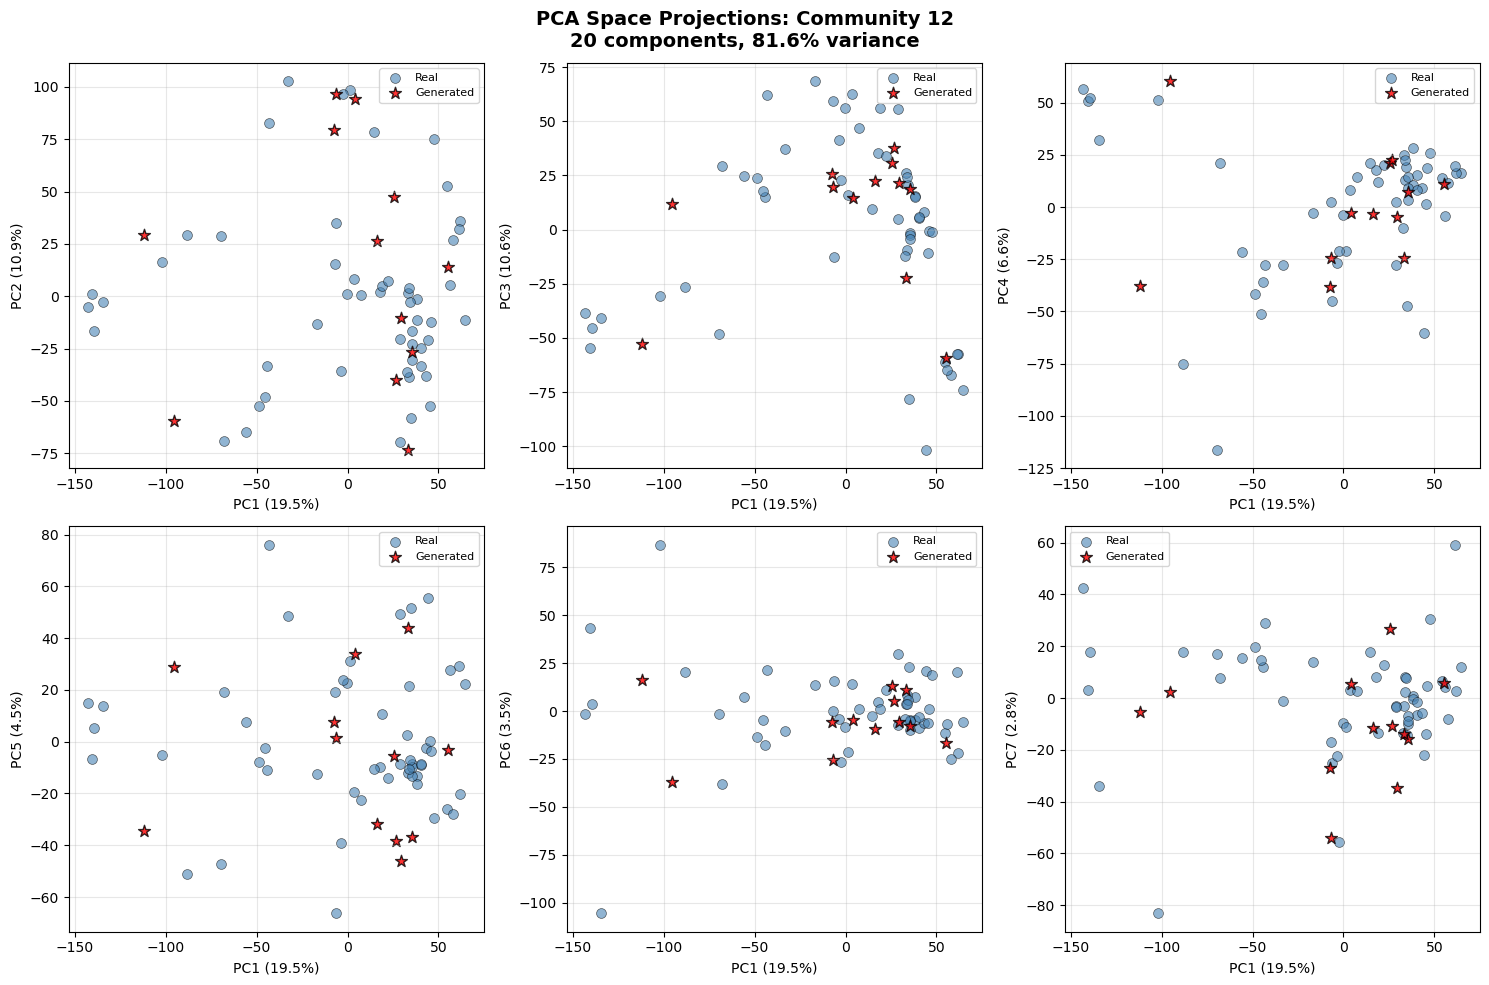

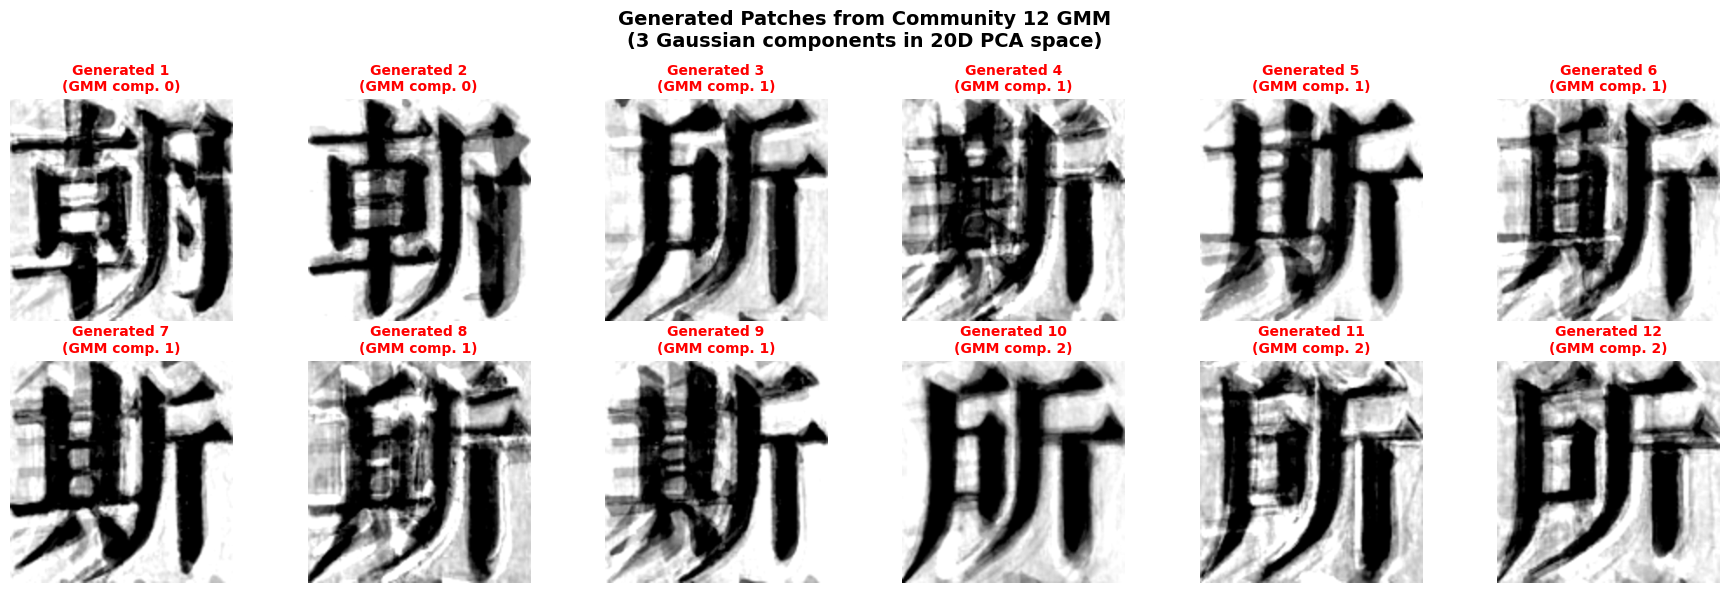

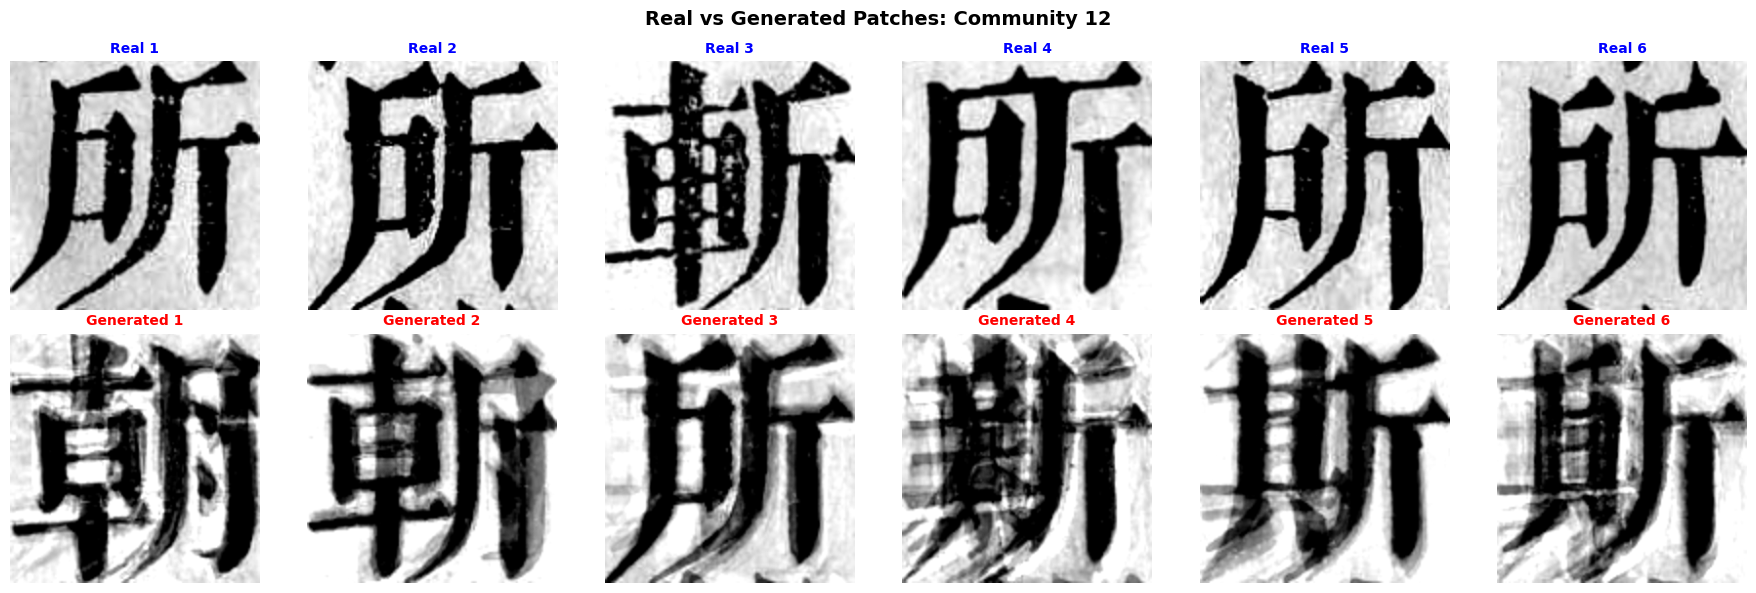


✓ Generation complete!
  - PCA captured 81.6% of variance with 20 components
  - GMM fit with 3 components (BIC: 7462.0)
  - Generated 12 new patches


In [ ]:
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np
import torch

# ============================================================================
# GMM GENERATION FROM COMMUNITY PCA SPACE
# ============================================================================

# Pick a random community (with minimum size for meaningful PCA)
MIN_SIZE_FOR_GMM = 50
valid_communities = [i for i, comm in enumerate(communities) if len(comm) >= MIN_SIZE_FOR_GMM]

if len(valid_communities) == 0:
    print(f"⚠️  No communities with at least {MIN_SIZE_FOR_GMM} patches found!")
else:
    # Select random community
    selected_comm_idx = np.random.choice(valid_communities)
    community_indices = list(communities[selected_comm_idx])
    community_size = len(community_indices)
    
    print(f"\n{'='*60}")
    print(f"GMM Generation from Community {selected_comm_idx}")
    print(f"{'='*60}")
    print(f"Community size: {community_size} patches")
    
    # Get patches from community
    community_patches = [extracted_image_patches[idx].unsqueeze(0) for idx in community_indices]
    community_patches_flat = torch.stack([patch.flatten() for patch in community_patches]).cpu().numpy()
    
    # Standardize
    scaler = StandardScaler()
    community_patches_scaled = scaler.fit_transform(community_patches_flat)
    
    # Apply PCA with n_components (can be 2 or more)
    n_components = min(20, community_size - 1)  # Adjust this number as needed
    pca = PCA(n_components=n_components)
    community_pca = pca.fit_transform(community_patches_scaled)
    
    print(f"PCA: {n_components} components explain {pca.explained_variance_ratio_.sum()*100:.1f}% variance")
    
    # Fit GMM on PCA space
    n_gmm_components = min(3, community_size // 3)  # Avoid overfitting
    gmm = GaussianMixture(n_components=n_gmm_components, random_state=42, covariance_type='full')
    gmm.fit(community_pca)
    
    print(f"GMM: fitted with {n_gmm_components} Gaussian components")
    print(f"GMM converged: {gmm.converged_}, iterations: {gmm.n_iter_}")
    
    # Generate new samples in PCA space
    n_generated = 12
    generated_pca, generated_labels = gmm.sample(n_generated)
    
    print(f"Generated {n_generated} new samples in PCA space")
    
    # Transform back to original space
    generated_scaled = pca.inverse_transform(generated_pca)
    generated_patches_flat = scaler.inverse_transform(generated_scaled)
    
    # Reshape to patch shape
    patch_shape = community_patches[0].shape
    generated_patches = [generated_patches_flat[i].reshape(patch_shape) for i in range(n_generated)]
    
    # Clip to valid range [0, 1] if needed
    generated_patches = [np.clip(patch, 0, 1) for patch in generated_patches]
    
    # ============================================================================
    # VISUALIZATION 1: PCA Space (only if n_components == 2 or visualizing first 2)
    # ============================================================================
    
    if n_components >= 2:
        plt.figure(figsize=(10, 8))
        
        # Plot real patches (first 2 PCs)
        plt.scatter(community_pca[:, 0], community_pca[:, 1], 
                   c='steelblue', s=100, alpha=0.6, edgecolors='black', linewidth=1,
                   label=f'Real patches (n={community_size})')
        
        # Plot generated patches (first 2 PCs)
        plt.scatter(generated_pca[:, 0], generated_pca[:, 1], 
                   c='red', s=150, alpha=0.8, marker='*', edgecolors='black', linewidth=1.5,
                   label=f'Generated patches (n={n_generated})')
        
        # Plot GMM contours (only for 2D visualization)
        if n_components == 2:
            x_min, x_max = community_pca[:, 0].min() - 1, community_pca[:, 0].max() + 1
            y_min, y_max = community_pca[:, 1].min() - 1, community_pca[:, 1].max() + 1
            xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
            Z = -gmm.score_samples(np.c_[xx.ravel(), yy.ravel()])
            Z = Z.reshape(xx.shape)
            plt.contour(xx, yy, Z, levels=10, linewidths=1, colors='orange', alpha=0.5)
            title_suffix = f'GMM with {n_gmm_components} components'
        else:
            title_suffix = f'First 2 of {n_components} PCs | GMM in {n_components}D space'
        
        plt.xlabel('PC 1', fontsize=12, fontweight='bold')
        plt.ylabel('PC 2', fontsize=12, fontweight='bold')
        plt.title(f'PCA Space: Community {selected_comm_idx}\n'
                  f'{title_suffix} | {pca.explained_variance_ratio_.sum()*100:.1f}% variance explained', 
                  fontsize=13, fontweight='bold')
        plt.legend(fontsize=11)
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.show()
    
    # ============================================================================
    # VISUALIZATION 1b: PCA Pairwise Scatter (if n_components > 2)
    # ============================================================================
    
    if n_components > 2:
        n_pairs_to_show = min(6, n_components * (n_components - 1) // 2)
        n_cols_pairs = 3
        n_rows_pairs = int(np.ceil(n_pairs_to_show / n_cols_pairs))
        
        fig, axs = plt.subplots(n_rows_pairs, n_cols_pairs, figsize=(15, 5 * n_rows_pairs))
        axs = np.atleast_2d(axs).ravel()
        
        pair_idx = 0
        for i in range(n_components):
            for j in range(i + 1, n_components):
                if pair_idx >= n_pairs_to_show:
                    break
                
                ax = axs[pair_idx]
                
                # Plot real patches
                ax.scatter(community_pca[:, i], community_pca[:, j], 
                          c='steelblue', s=50, alpha=0.6, edgecolors='black', linewidth=0.5,
                          label='Real')
                
                # Plot generated patches
                ax.scatter(generated_pca[:, i], generated_pca[:, j], 
                          c='red', s=80, alpha=0.8, marker='*', edgecolors='black', linewidth=1,
                          label='Generated')
                
                var_i = pca.explained_variance_ratio_[i] * 100
                var_j = pca.explained_variance_ratio_[j] * 100
                ax.set_xlabel(f'PC{i+1} ({var_i:.1f}%)', fontsize=10)
                ax.set_ylabel(f'PC{j+1} ({var_j:.1f}%)', fontsize=10)
                ax.legend(fontsize=8)
                ax.grid(alpha=0.3)
                
                pair_idx += 1
        
        # Hide unused subplots
        for idx in range(pair_idx, len(axs)):
            axs[idx].axis('off')
            axs[idx].set_visible(False)
        
        plt.suptitle(f'PCA Space Projections: Community {selected_comm_idx}\n'
                     f'{n_components} components, {pca.explained_variance_ratio_.sum()*100:.1f}% variance', 
                     fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()
    
    # ============================================================================
    # VISUALIZATION 2: Generated Patches
    # ============================================================================
    
    n_cols = min(6, n_generated)
    n_rows = int(np.ceil(n_generated / n_cols))
    
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(3 * n_cols, 3 * n_rows))
    axs = np.atleast_2d(axs).ravel()
    
    for i in range(n_generated):
        ax = axs[i]
        patch_tensor = torch.from_numpy(generated_patches[i]).float()
        ax.imshow(torch_to_pil(patch_tensor).resize((256, 256)), cmap="gray")
        ax.set_title(f'Generated {i+1}\n(GMM comp. {generated_labels[i]})', 
                    fontweight='bold', fontsize=10, color='red')
        ax.axis('off')
        for spine in ax.spines.values():
            spine.set_edgecolor('red')
            spine.set_linewidth(3)
            spine.set_visible(True)
    
    # Hide unused subplots
    for i in range(n_generated, len(axs)):
        axs[i].axis('off')
        axs[i].set_visible(False)
    
    plt.suptitle(f'Generated Patches from Community {selected_comm_idx} GMM\n'
                 f'({n_gmm_components} Gaussian components in {n_components}D PCA space)', 
                 fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # ============================================================================
    # VISUALIZATION 3: Comparison - Real vs Generated
    # ============================================================================
    
    # Show some real patches for comparison
    n_real_to_show = min(6, community_size)
    real_sample_indices = np.random.choice(len(community_indices), n_real_to_show, replace=False)
    
    fig, axs = plt.subplots(2, max(n_real_to_show, n_cols), 
                            figsize=(3 * max(n_real_to_show, n_cols), 6))
    
    # Top row: Real patches
    for i in range(n_real_to_show):
        ax = axs[0, i]
        patch_idx = community_indices[real_sample_indices[i]]
        ax.imshow(torch_to_pil(extracted_image_patches[patch_idx].unsqueeze(0)).resize((256, 256)), cmap="gray")
        ax.set_title(f'Real {i+1}', fontweight='bold', fontsize=10, color='blue')
        ax.axis('off')
        for spine in ax.spines.values():
            spine.set_edgecolor('blue')
            spine.set_linewidth(2)
            spine.set_visible(True)
    
    # Hide extra subplots in first row
    for i in range(n_real_to_show, axs.shape[1]):
        axs[0, i].axis('off')
        axs[0, i].set_visible(False)
    
    # Bottom row: Generated patches
    for i in range(min(n_generated, axs.shape[1])):
        ax = axs[1, i]
        patch_tensor = torch.from_numpy(generated_patches[i]).float()
        ax.imshow(torch_to_pil(patch_tensor).resize((256, 256)), cmap="gray")
        ax.set_title(f'Generated {i+1}', fontweight='bold', fontsize=10, color='red')
        ax.axis('off')
        for spine in ax.spines.values():
            spine.set_edgecolor('red')
            spine.set_linewidth(2)
            spine.set_visible(True)
    
    # Hide extra subplots in second row
    for i in range(min(n_generated, axs.shape[1]), axs.shape[1]):
        axs[1, i].axis('off')
        axs[1, i].set_visible(False)
    
    plt.suptitle(f'Real vs Generated Patches: Community {selected_comm_idx}', 
                 fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    print(f"\n✓ Generation complete!")
    print(f"  - PCA captured {pca.explained_variance_ratio_.sum()*100:.1f}% of variance with {n_components} components")
    print(f"  - GMM fit with {n_gmm_components} components (BIC: {gmm.bic(community_pca):.1f})")
    print(f"  - Generated {n_generated} new patches")

In [ ]:
%matplotlib tk

In [ ]:
(patches[communities[comms_to_save[0]].pop()]*255).to(torch.uint8).numpy()

error: OpenCV(4.11.0) :-1: error: (-5:Bad argument) in function 'imshow'
> Overload resolution failed:
>  - imshow() missing required argument 'mat' (pos 2)
>  - imshow() missing required argument 'mat' (pos 2)
>  - imshow() missing required argument 'mat' (pos 2)


(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)

In [ ]:
%matplotlib tk


https://arxiv.org/pdf/1511.00628

https://www.ipol.im/pub/art/2018/222/

https://en.wikipedia.org/wiki/Fisher%E2%80%93Tippett%E2%80%93Gnedenko_theorem


Parler à Diego -> du gaussianity test

Idées:
- Gaussianity test
- VP Tree pour scaler
- Preprocess les patchs avec l'algo de SVG
- Recalage avec l'algo d'IPOL

In [ ]:
# ============================================
# Community Statistics and Analysis
# ============================================

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Patch
import networkx as nx

# Create undirected version if not exists
if 'G_undirected' not in locals():
    if G.is_directed():
        G_undirected = G.to_undirected()
    else:
        G_undirected = G

# Compute degrees if not already computed
if 'in_degrees' not in locals():
    if G.is_directed():
        in_degrees = np.array([G.in_degree(i) for i in range(N)])
        out_degrees = np.array([G.out_degree(i) for i in range(N)])
    else:
        # For undirected graphs, in_degree = out_degree = degree
        in_degrees = np.array([G.degree(i) for i in range(N)])
        out_degrees = np.array([G.degree(i) for i in range(N)])
    
if 'degrees' not in locals():
    if G.is_directed():
        degrees = in_degrees + out_degrees
    else:
        degrees = np.array([G.degree(i) for i in range(N)])

print("=" * 70)
print("COMMUNITY STATISTICS")
print("=" * 70)

# Basic statistics
print(f"\nGraph type: {'Directed' if G.is_directed() else 'Undirected'}")
print(f"Total nodes: {N}")
print(f"Total edges: {G.number_of_edges()}")
print(f"Total communities: {len(communities)}")
print(f"Graph density: {nx.density(G_undirected):.4f}")

# Modularity (measure of community structure quality)
if G_undirected.number_of_edges() > 0:
    from networkx.algorithms import community as comm_module
    modularity = comm_module.modularity(G_undirected, communities)
    print(f"Modularity: {modularity:.4f} (higher is better, typically 0.3-0.7 is good)")

# Community size statistics
community_sizes = [len(comm) for comm in communities]
print(f"\nCommunity size statistics:")
print(f"  Mean: {np.mean(community_sizes):.2f}")
print(f"  Median: {np.median(community_sizes):.2f}")
print(f"  Min: {np.min(community_sizes)}")
print(f"  Max: {np.max(community_sizes)}")
print(f"  Std: {np.std(community_sizes):.2f}")

# Largest communities
print(f"\nTop 10 largest communities:")
sorted_communities = sorted(enumerate(communities), key=lambda x: len(x[1]), reverse=True)
for rank, (comm_idx, comm) in enumerate(sorted_communities[:10], 1):
    print(f"  {rank}. Community {comm_idx}: {len(comm)} nodes ({100*len(comm)/N:.1f}%)")

# Degree statistics per community
print(f"\nDegree statistics by community (top 5):")
for comm_idx, comm in sorted_communities[:5]:
    comm_degrees = degrees[list(comm)]
    if G.is_directed():
        comm_in = in_degrees[list(comm)]
        comm_out = out_degrees[list(comm)]
        print(f"  Community {comm_idx} ({len(comm)} nodes):")
        print(f"    Avg degree: {comm_degrees.mean():.2f} (in: {comm_in.mean():.2f}, out: {comm_out.mean():.2f})")
        print(f"    Max degree: {comm_degrees.max()} (in: {comm_in.max()}, out: {comm_out.max()})")
    else:
        print(f"  Community {comm_idx} ({len(comm)} nodes):")
        print(f"    Avg degree: {comm_degrees.mean():.2f}")
        print(f"    Max degree: {comm_degrees.max()}")

# Edge analysis
intra_edges = sum(1 for i, j in G.edges() 
                  if community_map.get(i, -1) == community_map.get(j, -1))
inter_edges = G.number_of_edges() - intra_edges
print(f"\nEdge distribution:")
print(f"  Intra-community edges: {intra_edges} ({100*intra_edges/G.number_of_edges():.1f}%)")
print(f"  Inter-community edges: {inter_edges} ({100*inter_edges/G.number_of_edges():.1f}%)")

# ============================================
# Visualizations
# ============================================

fig = plt.figure(figsize=(20, 12))

# 1. Community size distribution
ax1 = plt.subplot(2, 3, 1)
ax1.hist(community_sizes, bins=min(30, len(communities)), 
         color='steelblue', edgecolor='black', alpha=0.7)
ax1.set_xlabel('Community Size', fontsize=12)
ax1.set_ylabel('Frequency', fontsize=12)
ax1.set_title('Community Size Distribution', fontsize=13, fontweight='bold')
ax1.grid(alpha=0.3)

# 2. Top communities pie chart
ax2 = plt.subplot(2, 3, 2)
top_n = 10
top_communities = sorted_communities[:top_n]
top_sizes = [len(comm) for _, comm in top_communities]
other_size = N - sum(top_sizes)

if other_size > 0:
    labels = [f'C{idx} ({len(comm)})' for idx, comm in top_communities] + [f'Others ({other_size})']
    sizes = top_sizes + [other_size]
    colors_pie = [community_colors[idx] for idx, _ in top_communities] + [[0.8, 0.8, 0.8, 1.0]]
else:
    labels = [f'C{idx} ({len(comm)})' for idx, comm in top_communities]
    sizes = top_sizes
    colors_pie = [community_colors[idx] for idx, _ in top_communities]

ax2.pie(sizes, labels=labels, colors=colors_pie, autopct='%1.1f%%', startangle=90)
ax2.set_title(f'Top {top_n} Communities Distribution', fontsize=13, fontweight='bold')

# 3. Degree distribution
ax3 = plt.subplot(2, 3, 3)
ax3.hist(degrees, bins=50, color='coral', edgecolor='black', alpha=0.7)
ax3.set_xlabel('Total Degree', fontsize=12)
ax3.set_ylabel('Frequency', fontsize=12)
ax3.set_title('Node Degree Distribution', fontsize=13, fontweight='bold')
ax3.axvline(degrees.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {degrees.mean():.1f}')
ax3.legend()
ax3.grid(alpha=0.3)

# 4. In-degree vs Out-degree scatter (only for directed graphs)
ax4 = plt.subplot(2, 3, 4)
if G.is_directed():
    scatter = ax4.scatter(out_degrees, in_degrees, c=node_communities, 
                         cmap='tab20', s=50, alpha=0.6, edgecolors='black', linewidth=0.5)
    ax4.set_xlabel('Out-Degree', fontsize=12)
    ax4.set_ylabel('In-Degree', fontsize=12)
    ax4.set_title('In-Degree vs Out-Degree (colored by community)', fontsize=13, fontweight='bold')
    ax4.plot([0, max(out_degrees.max(), in_degrees.max())], 
             [0, max(out_degrees.max(), in_degrees.max())], 
             'r--', alpha=0.5, label='Equal in/out')
    ax4.legend()
else:
    # For undirected graph, show degree vs community size
    comm_sizes_per_node = [len(communities[community_map.get(i, 0)]) for i in range(N)]
    scatter = ax4.scatter(comm_sizes_per_node, degrees, c=node_communities,
                         cmap='tab20', s=50, alpha=0.6, edgecolors='black', linewidth=0.5)
    ax4.set_xlabel('Community Size', fontsize=12)
    ax4.set_ylabel('Node Degree', fontsize=12)
    ax4.set_title('Degree vs Community Size (colored by community)', fontsize=13, fontweight='bold')
ax4.grid(alpha=0.3)

# 5. Community connectivity matrix (top communities)
ax5 = plt.subplot(2, 3, 5)
top_comm_indices = [idx for idx, _ in sorted_communities[:10]]
connectivity_matrix = np.zeros((len(top_comm_indices), len(top_comm_indices)))

for i, j in G.edges():
    comm_i = community_map.get(i, -1)
    comm_j = community_map.get(j, -1)
    if comm_i in top_comm_indices and comm_j in top_comm_indices:
        i_idx = top_comm_indices.index(comm_i)
        j_idx = top_comm_indices.index(comm_j)
        connectivity_matrix[i_idx, j_idx] += 1
        if not G.is_directed() and i != j:
            # For undirected graphs, count both directions
            connectivity_matrix[j_idx, i_idx] += 1

im = ax5.imshow(connectivity_matrix, cmap='YlOrRd', aspect='auto')
ax5.set_xticks(range(len(top_comm_indices)))
ax5.set_yticks(range(len(top_comm_indices)))
ax5.set_xticklabels([f'C{idx}' for idx in top_comm_indices], rotation=45)
ax5.set_yticklabels([f'C{idx}' for idx in top_comm_indices])
if G.is_directed():
    ax5.set_xlabel('To Community', fontsize=12)
    ax5.set_ylabel('From Community', fontsize=12)
else:
    ax5.set_xlabel('Community', fontsize=12)
    ax5.set_ylabel('Community', fontsize=12)
ax5.set_title('Top 10 Communities Connectivity', fontsize=13, fontweight='bold')
plt.colorbar(im, ax=ax5, label='Number of edges')

# 6. Nodes per community (top 20)
ax6 = plt.subplot(2, 3, 6)
top_20_communities = sorted_communities[:20]
comm_labels = [f'C{idx}' for idx, _ in top_20_communities]
comm_sizes_top = [len(comm) for _, comm in top_20_communities]
colors_bars = [community_colors[idx] for idx, _ in top_20_communities]

bars = ax6.barh(range(len(comm_labels)), comm_sizes_top, color=colors_bars, edgecolor='black')
ax6.set_yticks(range(len(comm_labels)))
ax6.set_yticklabels(comm_labels)
ax6.set_xlabel('Number of Nodes', fontsize=12)
ax6.set_ylabel('Community', fontsize=12)
ax6.set_title('Top 20 Communities by Size', fontsize=13, fontweight='bold')
ax6.invert_yaxis()
ax6.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

# ============================================
# Additional Analysis
# ============================================

print("\n" + "=" * 70)
print("ISOLATED NODES AND HUBS")
print("=" * 70)

# Isolated nodes
isolated = [i for i in range(N) if degrees[i] == 0]
print(f"\nIsolated nodes (degree = 0): {len(isolated)}")
if len(isolated) > 0 and len(isolated) <= 10:
    print(f"  Node indices: {isolated}")

# Hub nodes (high degree)
degree_threshold = np.percentile(degrees[degrees > 0], 90) if len(degrees[degrees > 0]) > 0 else 0
hubs = [(i, degrees[i], in_degrees[i], out_degrees[i]) 
        for i in range(N) if degrees[i] >= degree_threshold]
hubs.sort(key=lambda x: x[1], reverse=True)

print(f"\nTop 10 hub nodes (≥ 90th percentile degree = {degree_threshold:.0f}):")
for rank, (node, deg, in_deg, out_deg) in enumerate(hubs[:10], 1):
    comm = community_map.get(node, -1)
    if G.is_directed():
        print(f"  {rank}. Node {node}: degree={deg} (in={in_deg}, out={out_deg}), community={comm}")
    else:
        print(f"  {rank}. Node {node}: degree={deg}, community={comm}")

# Inter-community bridge nodes
print(f"\nBridge nodes (nodes connecting multiple communities):")
bridge_nodes = []
for node in range(N):
    neighbors_communities = set()
    for neighbor in G.neighbors(node):
        neighbors_communities.add(community_map.get(neighbor, -1))
    if len(neighbors_communities) > 1:
        bridge_nodes.append((node, len(neighbors_communities), degrees[node]))

bridge_nodes.sort(key=lambda x: (x[1], x[2]), reverse=True)
print(f"  Total bridge nodes: {len(bridge_nodes)}")
if len(bridge_nodes) > 0:
    print(f"  Top 10 bridges:")
    for rank, (node, n_comms, deg) in enumerate(bridge_nodes[:10], 1):
        print(f"    {rank}. Node {node}: connects {n_comms} communities, degree={deg}")

print("\n" + "=" * 70)

COMMUNITY STATISTICS

Graph type: Undirected
Total nodes: 14628
Total edges: 242043
Total communities: 4237
Graph density: 0.0023
Modularity: 0.8422 (higher is better, typically 0.3-0.7 is good)

Community size statistics:
  Mean: 3.45
  Median: 1.00
  Min: 1
  Max: 435
  Std: 16.69

Top 10 largest communities:
  1. Community 0: 435 nodes (3.0%)
  2. Community 1: 394 nodes (2.7%)
  3. Community 2: 394 nodes (2.7%)
  4. Community 3: 343 nodes (2.3%)
  5. Community 4: 284 nodes (1.9%)
  6. Community 5: 223 nodes (1.5%)
  7. Community 6: 184 nodes (1.3%)
  8. Community 7: 154 nodes (1.1%)
  9. Community 8: 152 nodes (1.0%)
  10. Community 9: 149 nodes (1.0%)

Degree statistics by community (top 5):
  Community 0 (435 nodes):
    Avg degree: 113.19
    Max degree: 245
  Community 1 (394 nodes):
    Avg degree: 249.56
    Max degree: 362
  Community 2 (394 nodes):
    Avg degree: 296.73
    Max degree: 372
  Community 3 (343 nodes):
    Avg degree: 75.08
    Max degree: 173
  Community 4 (2

NameError: name 'community_map' is not defined